In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import os
import re
import json
import operator
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import nnls
import warnings
import networkx as nx
from random import shuffle
warnings.filterwarnings('ignore')
%load_ext autotime
%matplotlib inline 

In [3]:
with open('software_counts.json') as json_data:
    software_counts = json.load(json_data)
with open('skills_counts.json') as json_data:
    skills_counts = json.load(json_data)
with open('qualification_counts.json') as json_data:
    qualification_counts = json.load(json_data)
    
with open('mean_salary_by_software.json') as json_data:
    mean_salary_by_software = json.load(json_data)
with open('salary_by_software.json') as json_data:
    salary_by_software = json.load(json_data)
    
with open('mean_salary_by_skill.json') as json_data:
    mean_salary_by_skill = json.load(json_data)
with open('salary_by_skill.json') as json_data:
    salary_by_skill = json.load(json_data)
    
with open('mean_salary_by_qualification.json') as json_data:
    mean_salary_by_qualification = json.load(json_data)
with open('salary_by_qualification.json') as json_data:
    salary_by_qualification = json.load(json_data)
    
jobs_df = pd.read_csv("jobs_df.csv", index_col=0)

time: 1.3 s


In [4]:
titles = []
salary = []
rating = []
descriptions = []
states = []
job_per_state = pd.DataFrame(columns=['State', "Jobs"])
for file in os.listdir("Job_Data")[2:]:
    state_name = file[:-5].replace("_", " ").title()
    with open('Job_Data/' + file) as json_data:
        data = json.load(json_data)
    job_per_state = job_per_state.append(pd.Series([state_name, len(data)], index=['State', "Jobs"]), ignore_index=True)
    for job in data:
        titles.append(re.sub("Sr\.* ", "Senior ", job['job_title']))
        salary.append(job['median_salary'])
        rating.append(job['company_rating'])
        descriptions.append(job['job_description'])
        states.append(state_name)
clean = re.compile('<.*?>')
descriptions = [re.sub(clean, '', description) for description in descriptions]
job_per_state = job_per_state.sort_values('Jobs', ascending=False)

time: 5.89 s


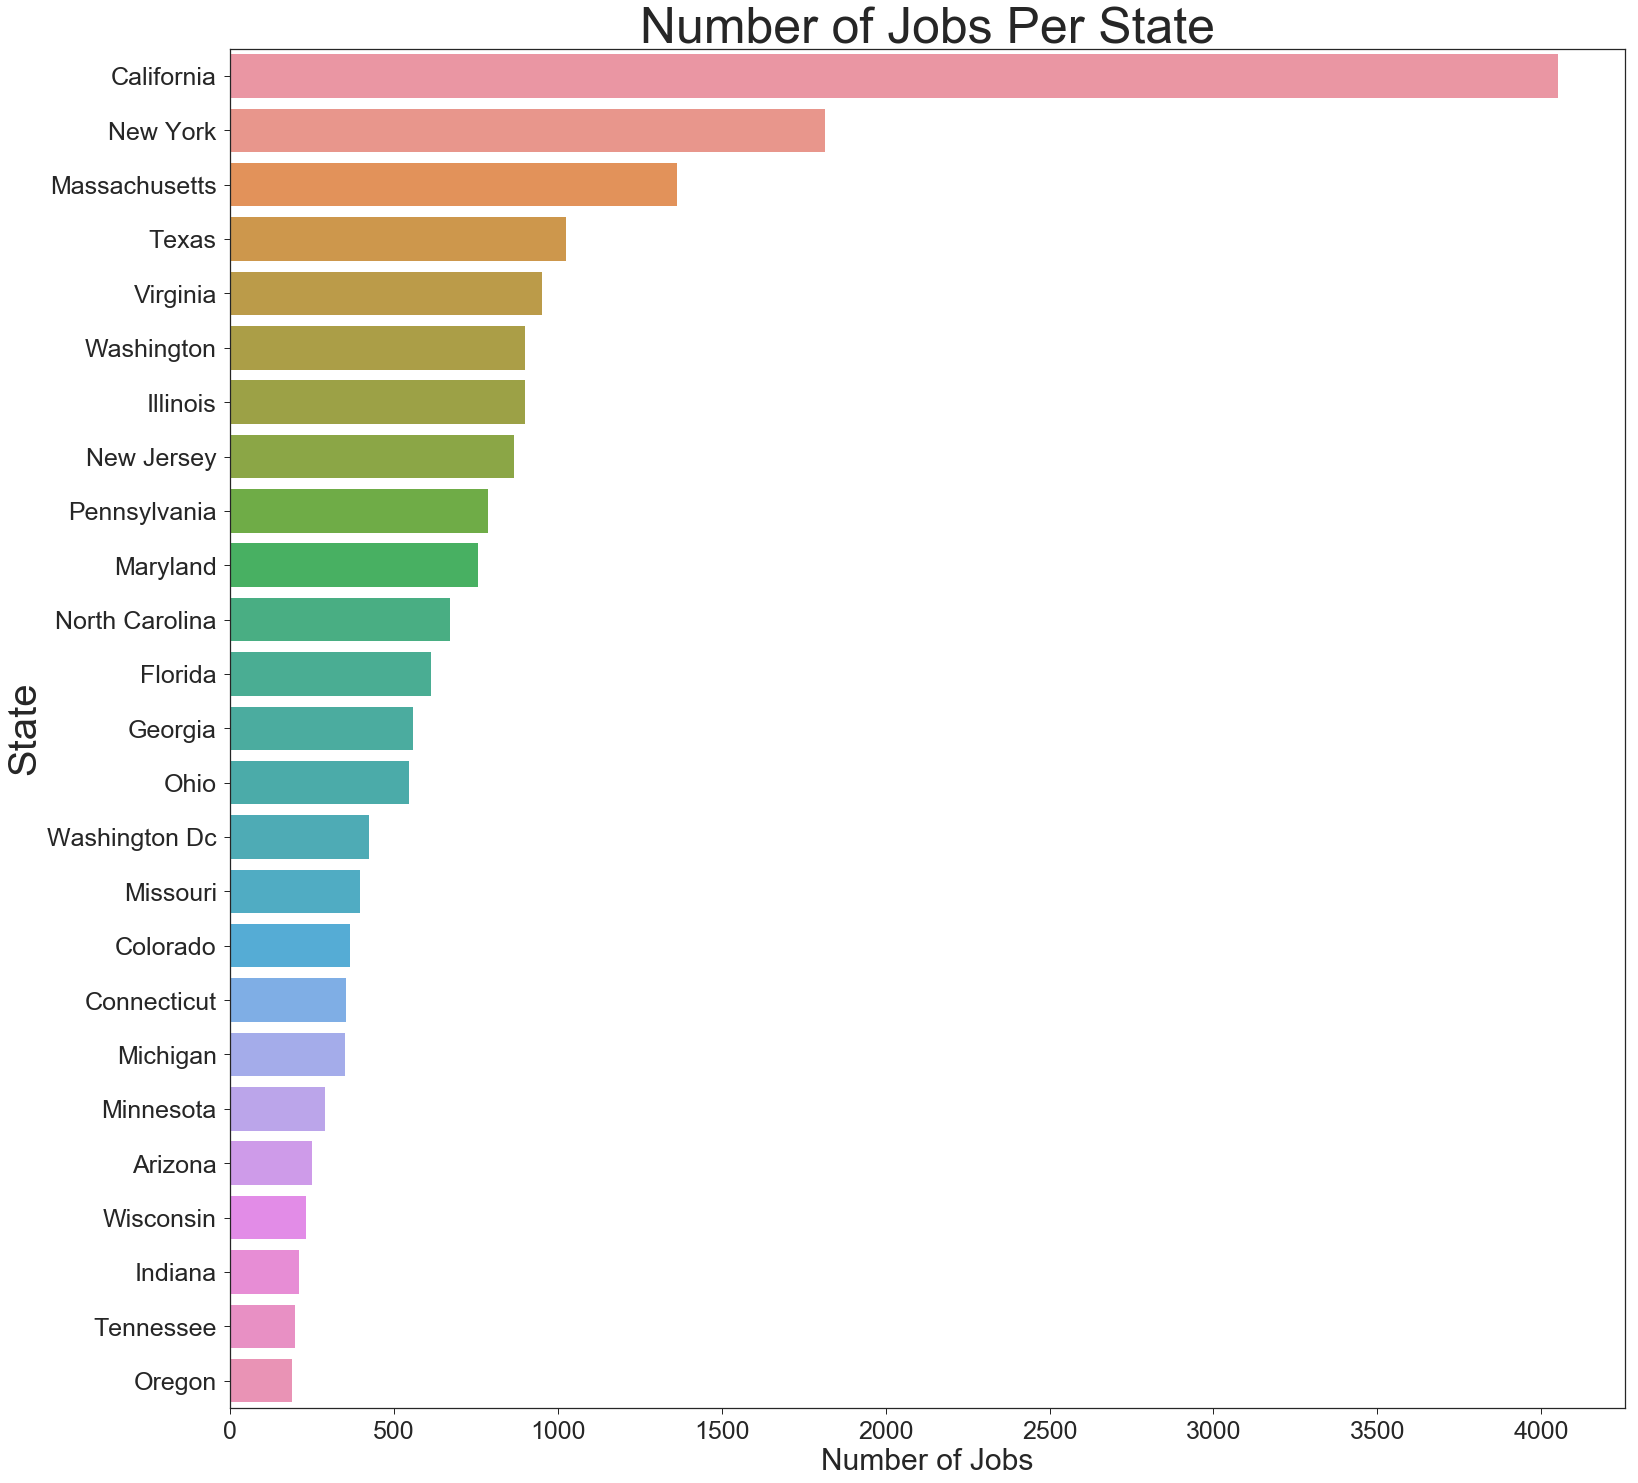

time: 1.27 s


In [629]:
sns.set(style="ticks")
f, ax = plt.subplots(figsize=(25, 25))
plot = sns.barplot(job_per_state.Jobs[0:25], job_per_state.State[0:25])
plot.set_xlabel("Number of Jobs",fontsize=30)
plot.set_ylabel("State",fontsize=40)
plot.set_title("Number of Jobs Per State", fontsize=50)
plot.tick_params(labelsize=25)
plot.plot([0,0], [-25,55], 'r--', linewidth = 0)

In [634]:
raw_title_counts = sorted(Counter(titles).items(), key=operator.itemgetter(1), reverse=True)
title_counts = pd.DataFrame(columns=['Title', "Count"])
for item in raw_title_counts[0:100]:
    title_counts = title_counts.append(pd.Series([item[0], item[1]], index=['Title', "Count"]), ignore_index=True)

time: 313 ms


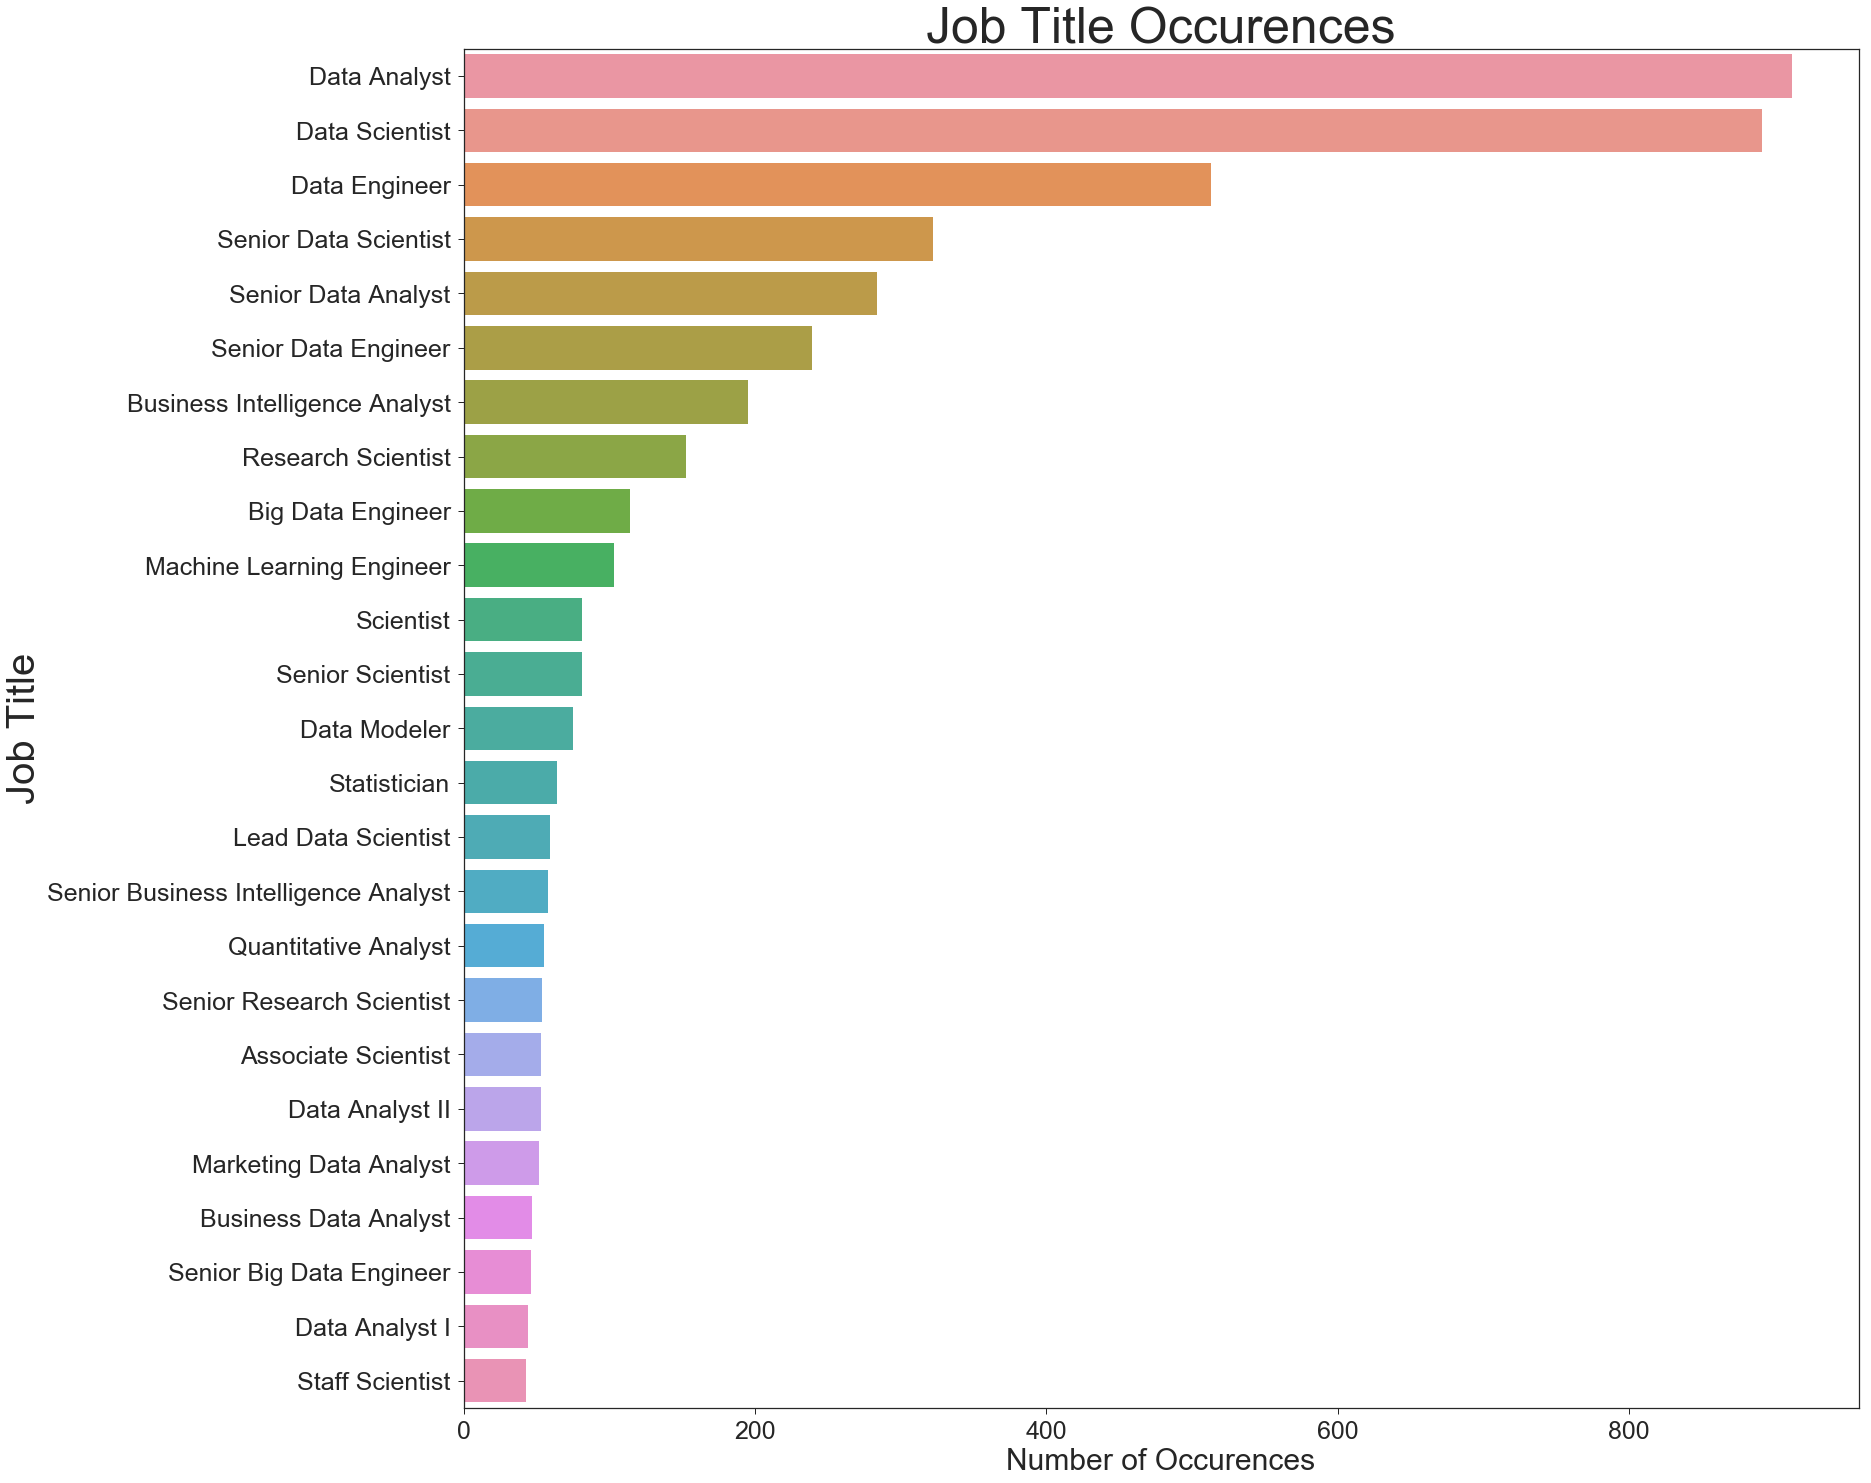

time: 1.4 s


In [638]:
sns.set(style="ticks")
f, ax = plt.subplots(figsize=(25, 25))
plot = sns.barplot(title_counts.Count[0:25], title_counts.Title[0:25])
plot.set_xlabel("Number of Occurences",fontsize=30)
plot.set_ylabel("Job Title",fontsize=40)
plot.set_title("Job Title Occurences", fontsize=50)
plot.tick_params(labelsize=25)
plot.plot([0,0], [-25,55], 'r--', linewidth = 0)

In [656]:
raw_software_counts = sorted(Counter(software_counts).items(), key=operator.itemgetter(1), reverse=True)
Softwares = pd.DataFrame(columns=['Software', "Count"])
for item in raw_software_counts[0:25]:
    Softwares = Softwares.append(pd.Series([item[0], item[1]], index=['Software', "Count"]), ignore_index=True)

time: 75.8 ms


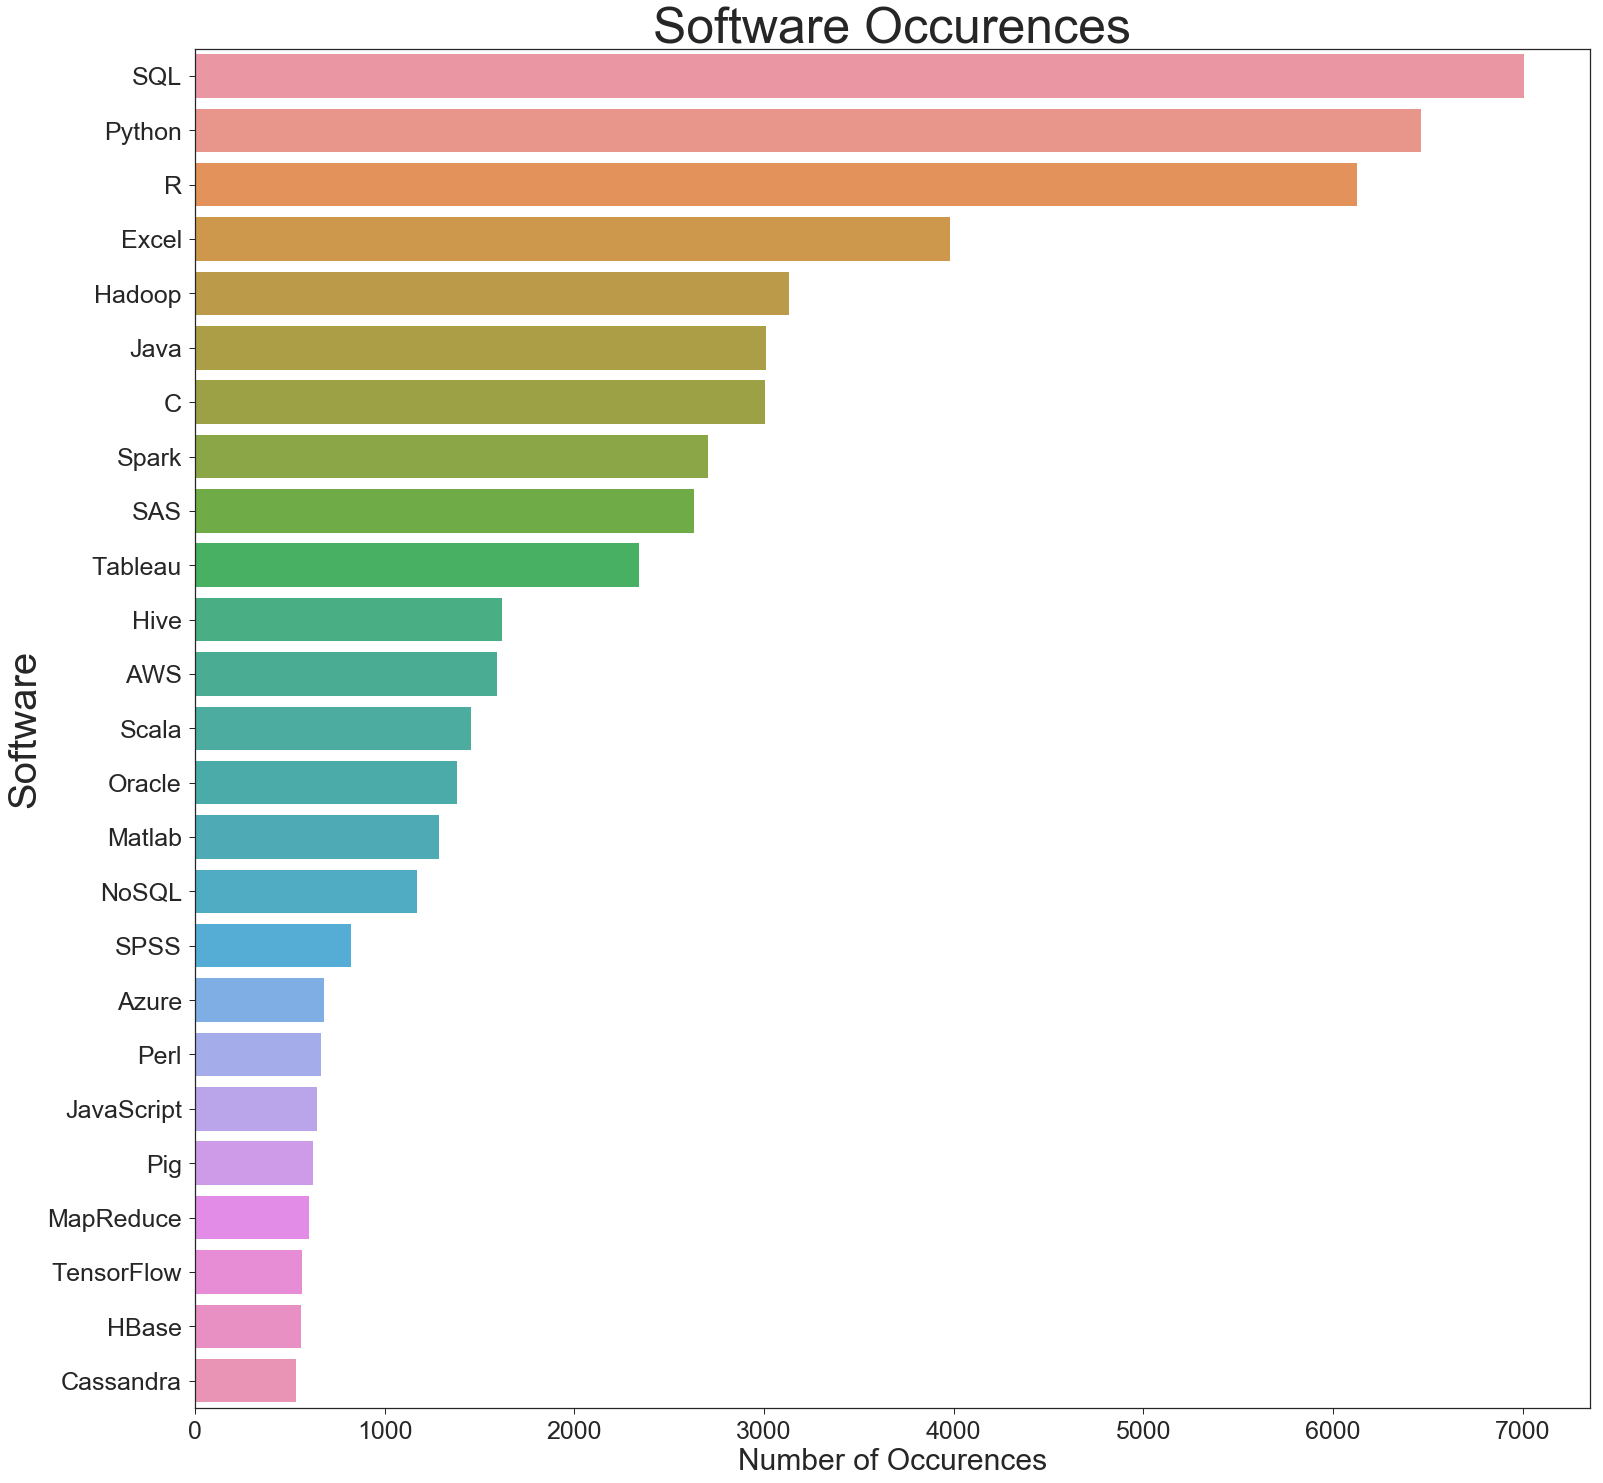

time: 1.25 s


In [657]:
sns.set(style="ticks")
f, ax = plt.subplots(figsize=(25, 25))
plot = sns.barplot(Softwares.Count[0:25], Softwares.Software[0:25])
plot.set_xlabel("Number of Occurences",fontsize=30)
plot.set_ylabel("Software",fontsize=40)
plot.set_title("Software Occurences", fontsize=50)
plot.tick_params(labelsize=25)
plot.plot([0,0], [-25,55], 'r--', linewidth = 0)

In [647]:
raw_skills_counts = sorted(Counter(skills_counts).items(), key=operator.itemgetter(1), reverse=True)
skills = pd.DataFrame(columns=['Skill', "Count"])
for item in raw_skills_counts[0:25]:
    skills = skills.append(pd.Series([item[0], item[1]], index=['Skill', "Count"]), ignore_index=True)

time: 77.8 ms


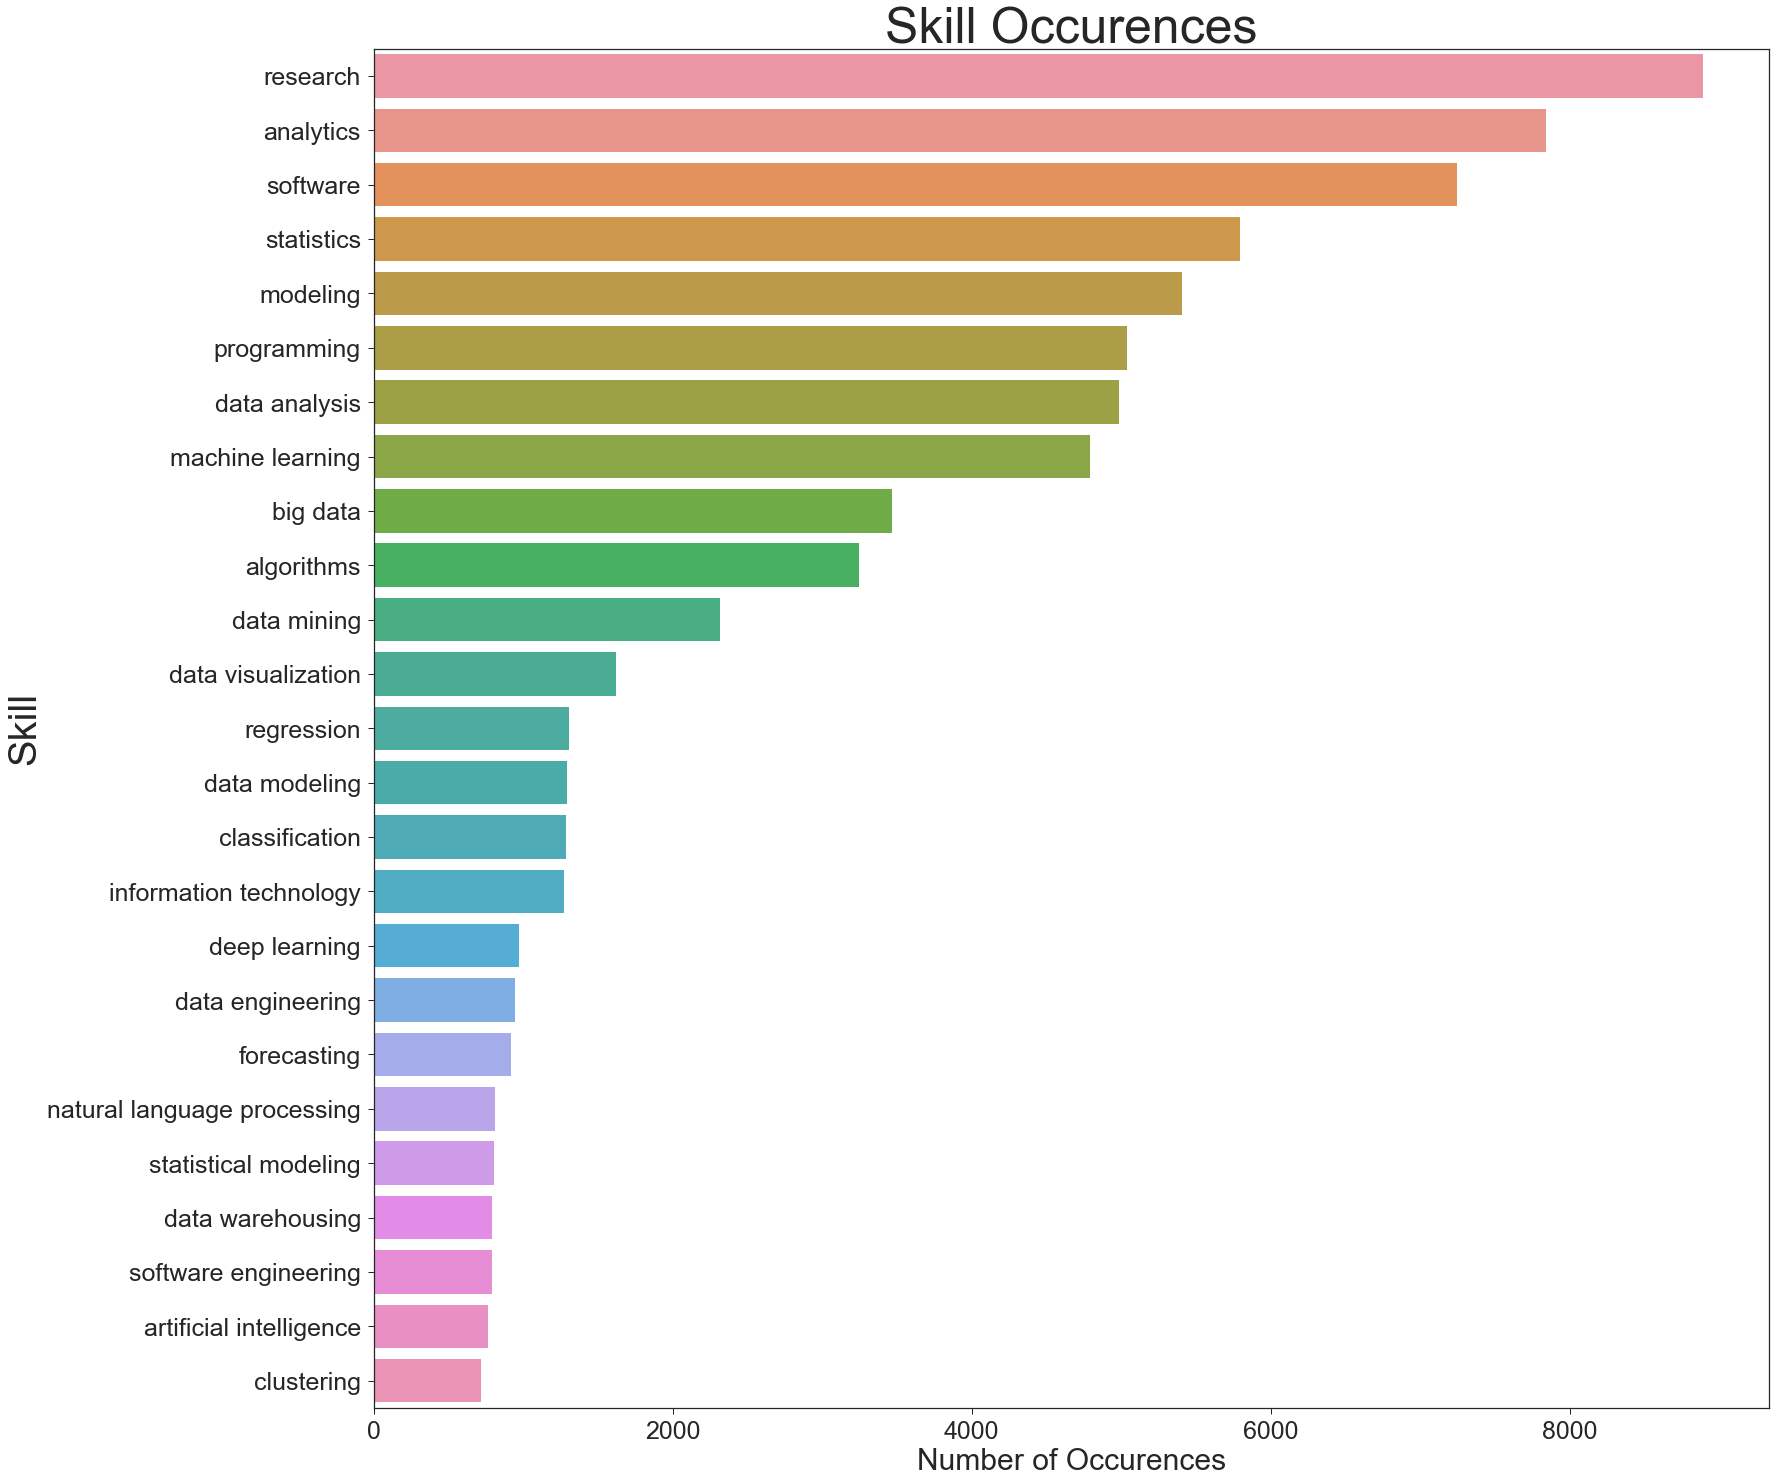

time: 1.27 s


In [654]:
sns.set(style="ticks")
f, ax = plt.subplots(figsize=(25, 25))
plot = sns.barplot(skills.Count[0:25], skills.Skill[0:25])
plot.set_xlabel("Number of Occurences",fontsize=30)
plot.set_ylabel("Skill",fontsize=40)
plot.set_title("Skill Occurences", fontsize=50)
plot.tick_params(labelsize=25)
plot.plot([0,0], [-25,55], 'r--', linewidth = 0)

In [665]:
qualification_counts

{'bachelor': 4909, 'master': 3202, 'phd': 5038}

time: 11.5 ms


In [189]:
jobs_df['Big_Data'] = jobs_df.loc[:,['Hadoop', 'Spark', 'Hive', 'Cassandra', 'Pig', 'MapReduce']].any(axis=1)*1
jobs_df['Scripting'] = jobs_df.loc[:,['JavaScript', 'Perl', 'Python', 'R']].any(axis=1)*1
jobs_df['Object_Oriented'] = jobs_df.loc[:,['C', 'Java', 'Perl', 'Python', 'Scala']].any(axis=1)*1

time: 446 ms


In [190]:
# Fit a non-negative least squares regression
jobs_df = jobs_df[np.isfinite(jobs_df['Salary'])]
model_data = jobs_df[jobs_df['Object_Oriented']!=2]
model = nnls(model_data.loc[:,"TensorFlow":"wisconsin"], model_data['Salary'])[0]

time: 392 ms


In [191]:
# Plot the value added for each software, where the value is greater than 0
values = []
softwares = []
for idx,value in enumerate(model[0:25]):
    if value > 0:
        values.append(value)
        softwares.append(mean_salary_by_software[idx][0])
software_value = pd.DataFrame({'Software': softwares,'Value_Added': values}).sort_values('Value_Added', ascending=False)

time: 8 ms


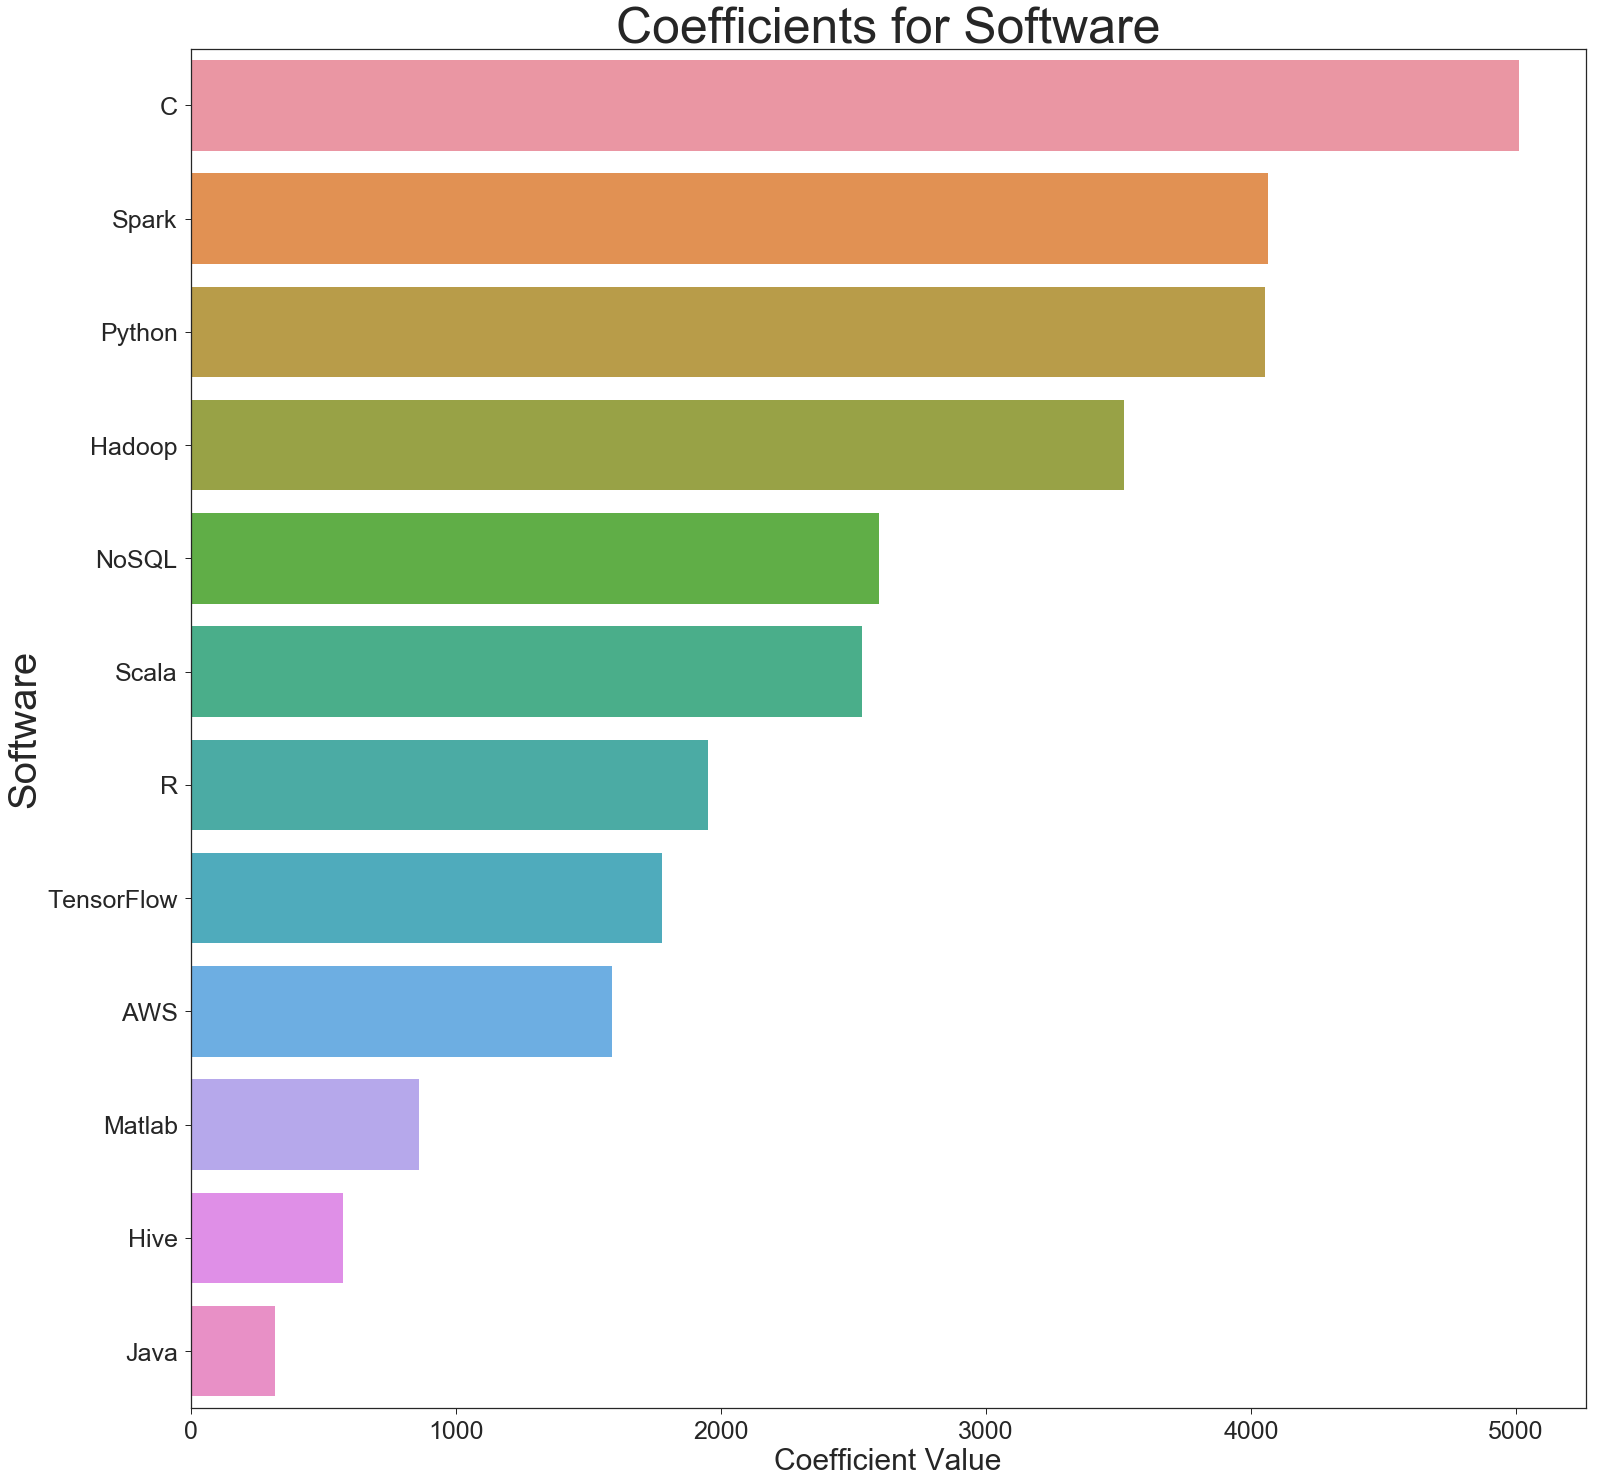

time: 1.15 s


In [192]:
sns.set(style="ticks")
f, ax = plt.subplots(figsize=(25, 25))
plot = sns.barplot(software_value.Value_Added, software_value.Software)
plot.set_xlabel("Coefficient Value",fontsize=30)
plot.set_ylabel("Software",fontsize=40)
plot.set_title("Coefficients for Software", fontsize=50)
plot.tick_params(labelsize=25)
plot.plot([0,0], [-25,55], 'r--', linewidth = 0)

In [85]:
# Plot the value added for each skill, where the value is greater than 0
values = []
skills = []
for idx,value in enumerate(model[25:50]):
    if value > 0:
        values.append(value)
        skills.append(mean_salary_by_skill[idx][0])
skill_value = pd.DataFrame({'Skill': skills,'Value_Added': values}).sort_values('Value_Added', ascending=False)

time: 4.18 ms


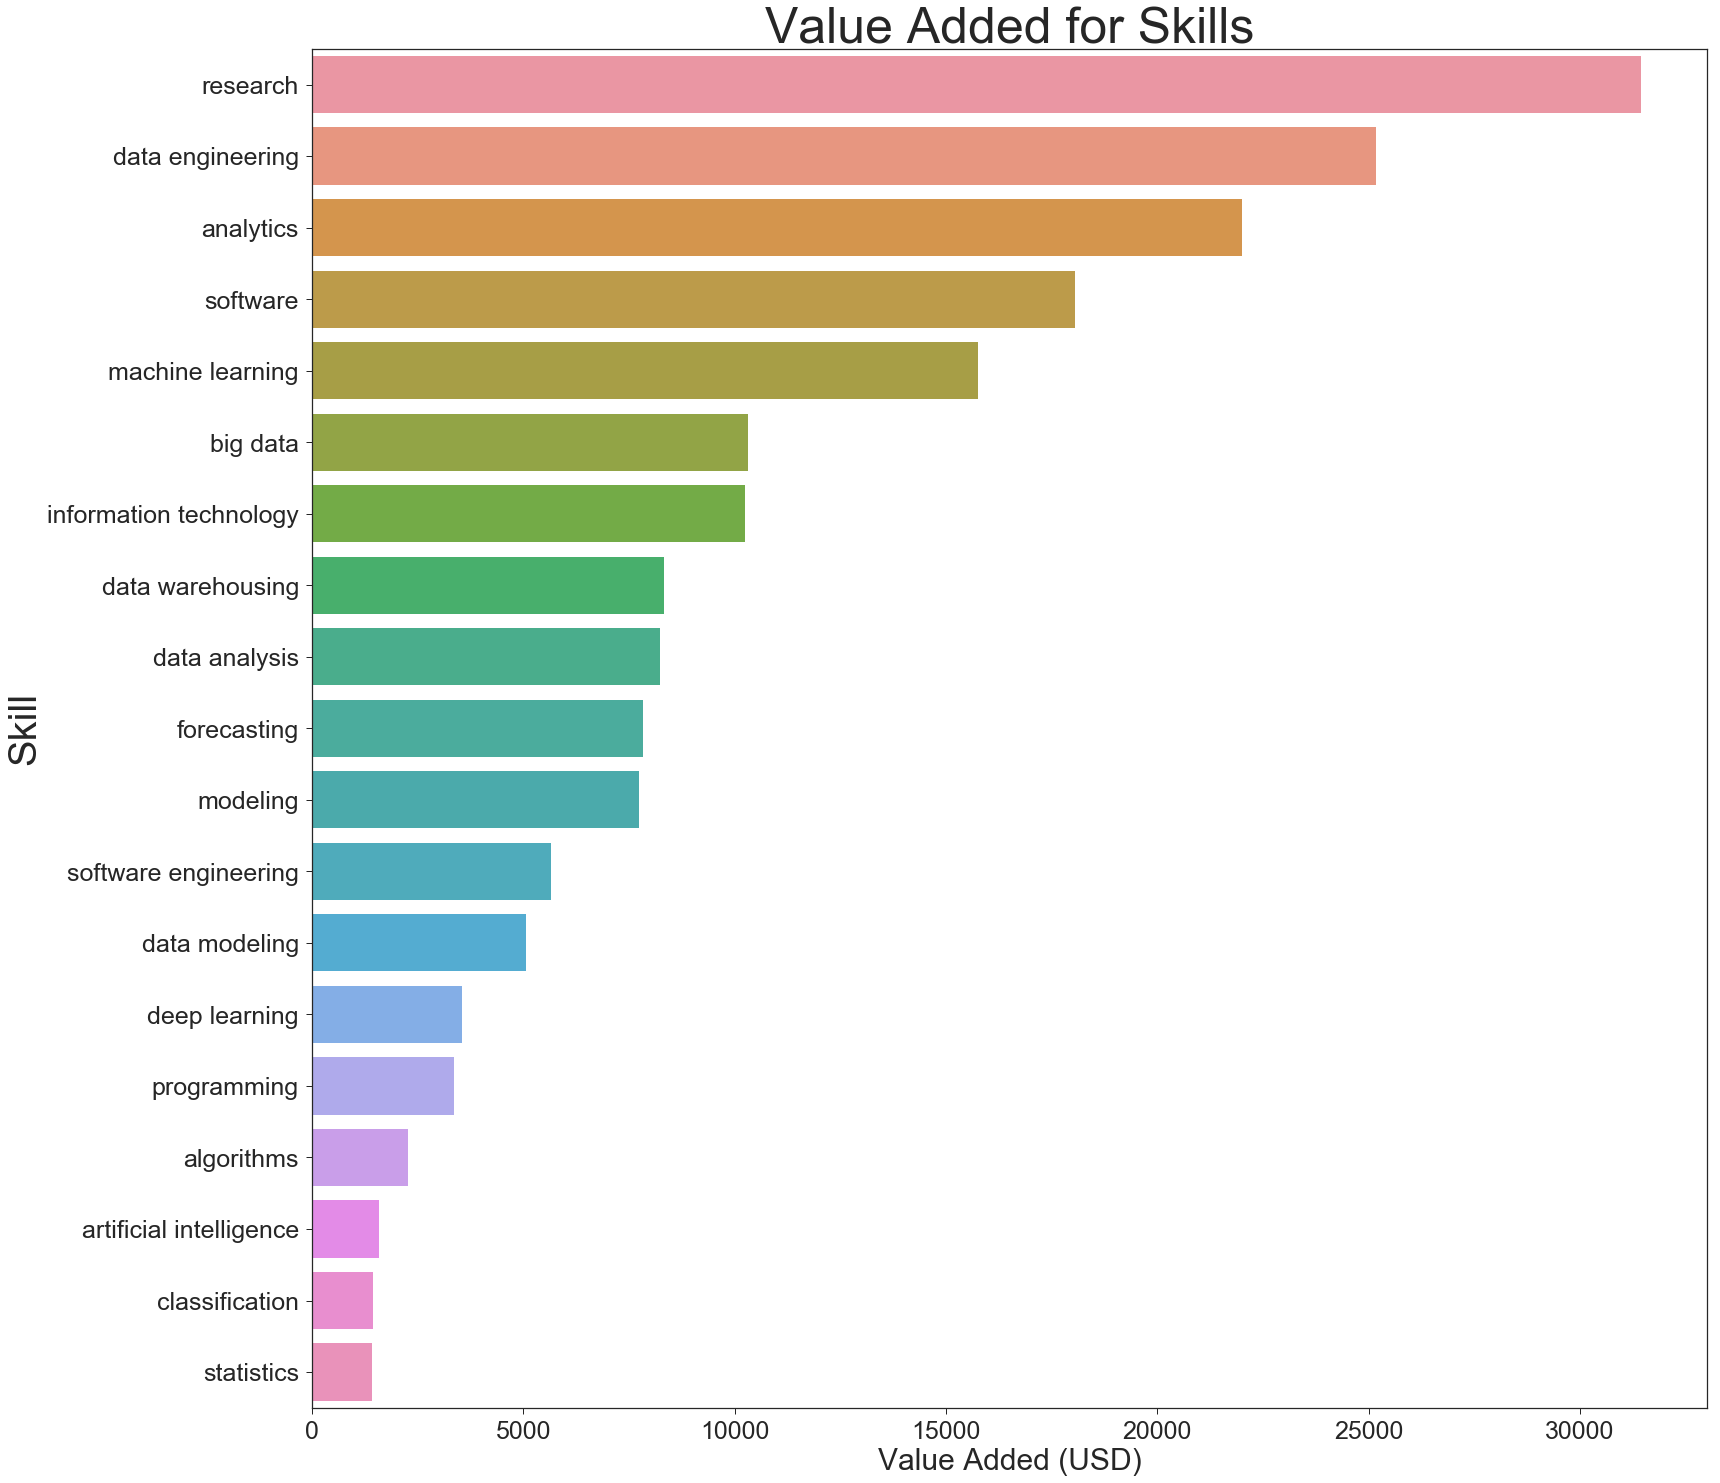

time: 1.22 s


In [25]:
sns.set(style="ticks")
f, ax = plt.subplots(figsize=(25, 25))
plot = sns.barplot(skill_value.Value_Added, skill_value.Skill)
plot.set_xlabel("Value Added (USD)",fontsize=30)
plot.set_ylabel("Skill",fontsize=40)
plot.set_title("Value Added for Skills", fontsize=50)
plot.tick_params(labelsize=25)
plot.plot([0,0], [-25,55], 'r--', linewidth = 0)

In [685]:
# Plot the value added for each state
values = []
state_names = []
for idx,value in enumerate(model[53:]):
    values.append(value)
    state_names.append(mean_salary_by_state[idx][0])
state_value = pd.DataFrame({'State': state_names,'Value_Added': values}).sort_values('Value_Added', ascending=False)

time: 12.9 ms


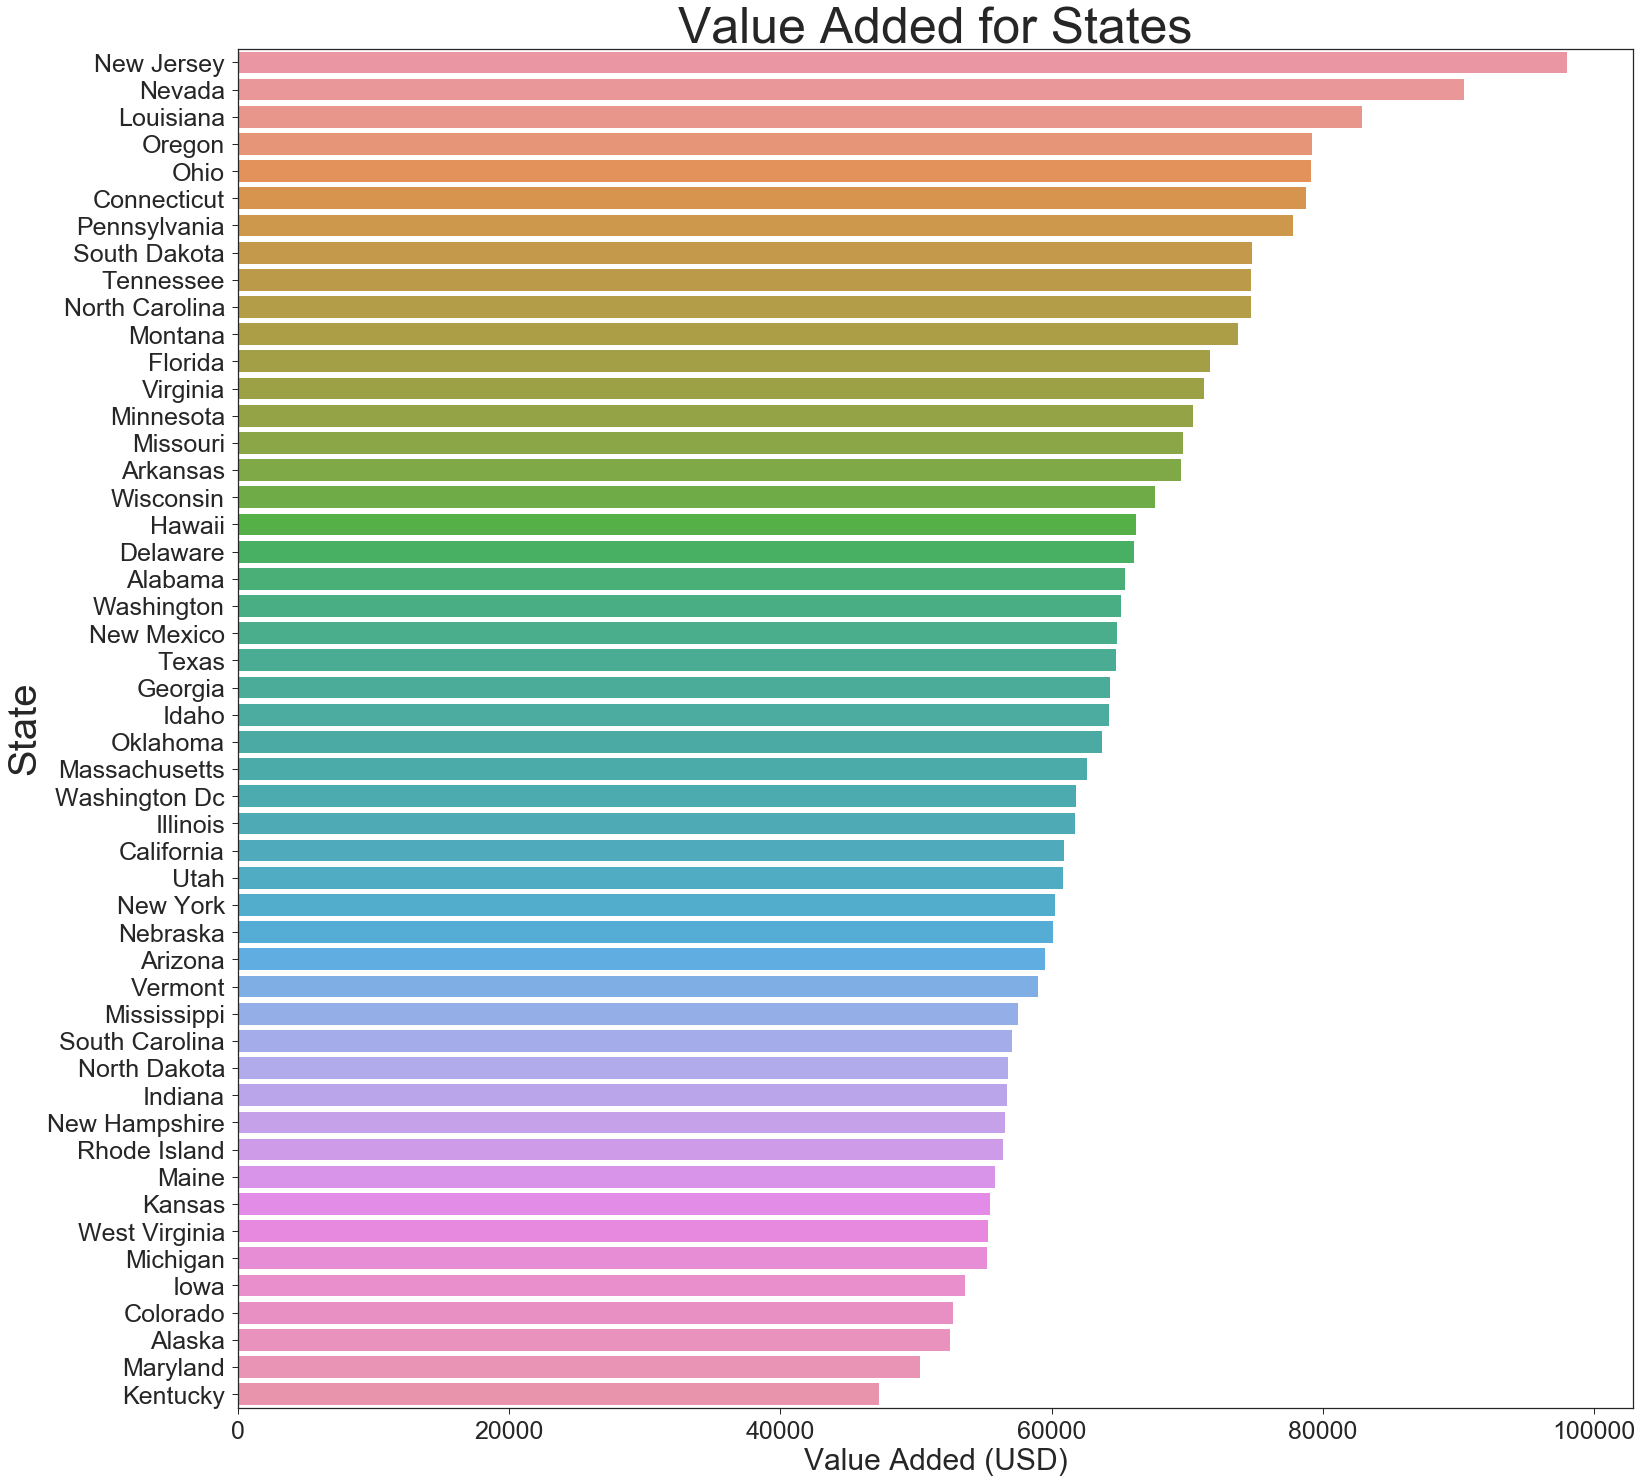

time: 2.47 s


In [688]:
sns.set(style="ticks")
f, ax = plt.subplots(figsize=(25, 25))
plot = sns.barplot(state_value.Value_Added, [State.title() for State in state_value.State])
plot.set_xlabel("Value Added (USD)",fontsize=30)
plot.set_ylabel("State",fontsize=40)
plot.set_title("Value Added for States", fontsize=50)
plot.tick_params(labelsize=25)
plot.plot([0,0], [-25,55], 'r--', linewidth = 0)

In [689]:
# Plot the value added for each degree level
values = []
qualifications = []
for idx,value in enumerate(model[50:53]):
    values.append(value)
    qualifications.append(mean_salary_by_qualification[idx][0])
qualification_value = pd.DataFrame({'Qualification': qualifications,'Value_Added': values}).sort_values('Value_Added', ascending=False)
qualification_value

,Qualification,Value_Added
0,phd,10504.877082
1,master,113.246681
2,bachelor,0.000000


time: 58.1 ms


In [222]:
# Get top 25 correlated skills/softwares
abs_corr_matrix = jobs_df.loc[:,[soft[0] for soft in sorted(Counter(software_counts).items(), key=operator.itemgetter(1), reverse=True)[0:15]]].corr().abs()
sorted_cors = abs_corr_matrix.unstack().sort_values(kind="quicksort", ascending=False)
top_25_cors = sorted_cors[16:][::2]
corr_pairs = top_25_cors.index
correaltion_df = pd.DataFrame(columns=['Attribute_1', 'Attribute_2', 'Correlation'])
for idx,corr_pair in enumerate(corr_pairs):
    correaltion_df = correaltion_df.append(pd.Series([corr_pair[0],corr_pair[1], top_25_cors[idx]], 
                                                     index=['Attribute_1', 'Attribute_2', 'Correlation']), ignore_index=True)

time: 302 ms


In [223]:
correaltion_df.T

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
Attribute_1,Hadoop,Hive,Scala,R,Spark,Java,Java,Spark,Scala,Spark,...,Matlab,AWS,SAS,Java,C,Scala,SAS,C,Tableau,Scala
Attribute_2,Spark,Hadoop,Spark,Python,Hive,Scala,Python,Java,Hadoop,AWS,...,SQL,C,Spark,Tableau,Oracle,SAS,Java,SAS,Scala,Oracle
Correlation,0.599303,0.50193,0.498755,0.468089,0.4265,0.426482,0.408807,0.366998,0.354506,0.348177,...,0.0158308,0.0156456,0.015101,0.0122565,0.0100544,0.00881733,0.00721891,0.00709219,0.00549747,0.00325129


time: 35.8 ms


In [224]:
G = nx.Graph()

time: 4.08 ms


In [225]:
top_15_software = sorted(Counter(software_counts).items(), key=operator.itemgetter(1), reverse=True)[0:15]
shuffle(top_15_software)
for software in top_15_software:
    G.add_node(software[0], nodesize=software[1])

time: 7.48 ms


In [303]:
for index, row in correaltion_df.iterrows():
    G.add_weighted_edges_from([(row['Attribute_1'], row['Attribute_2'], row['Correlation']*15)])

time: 30.3 ms


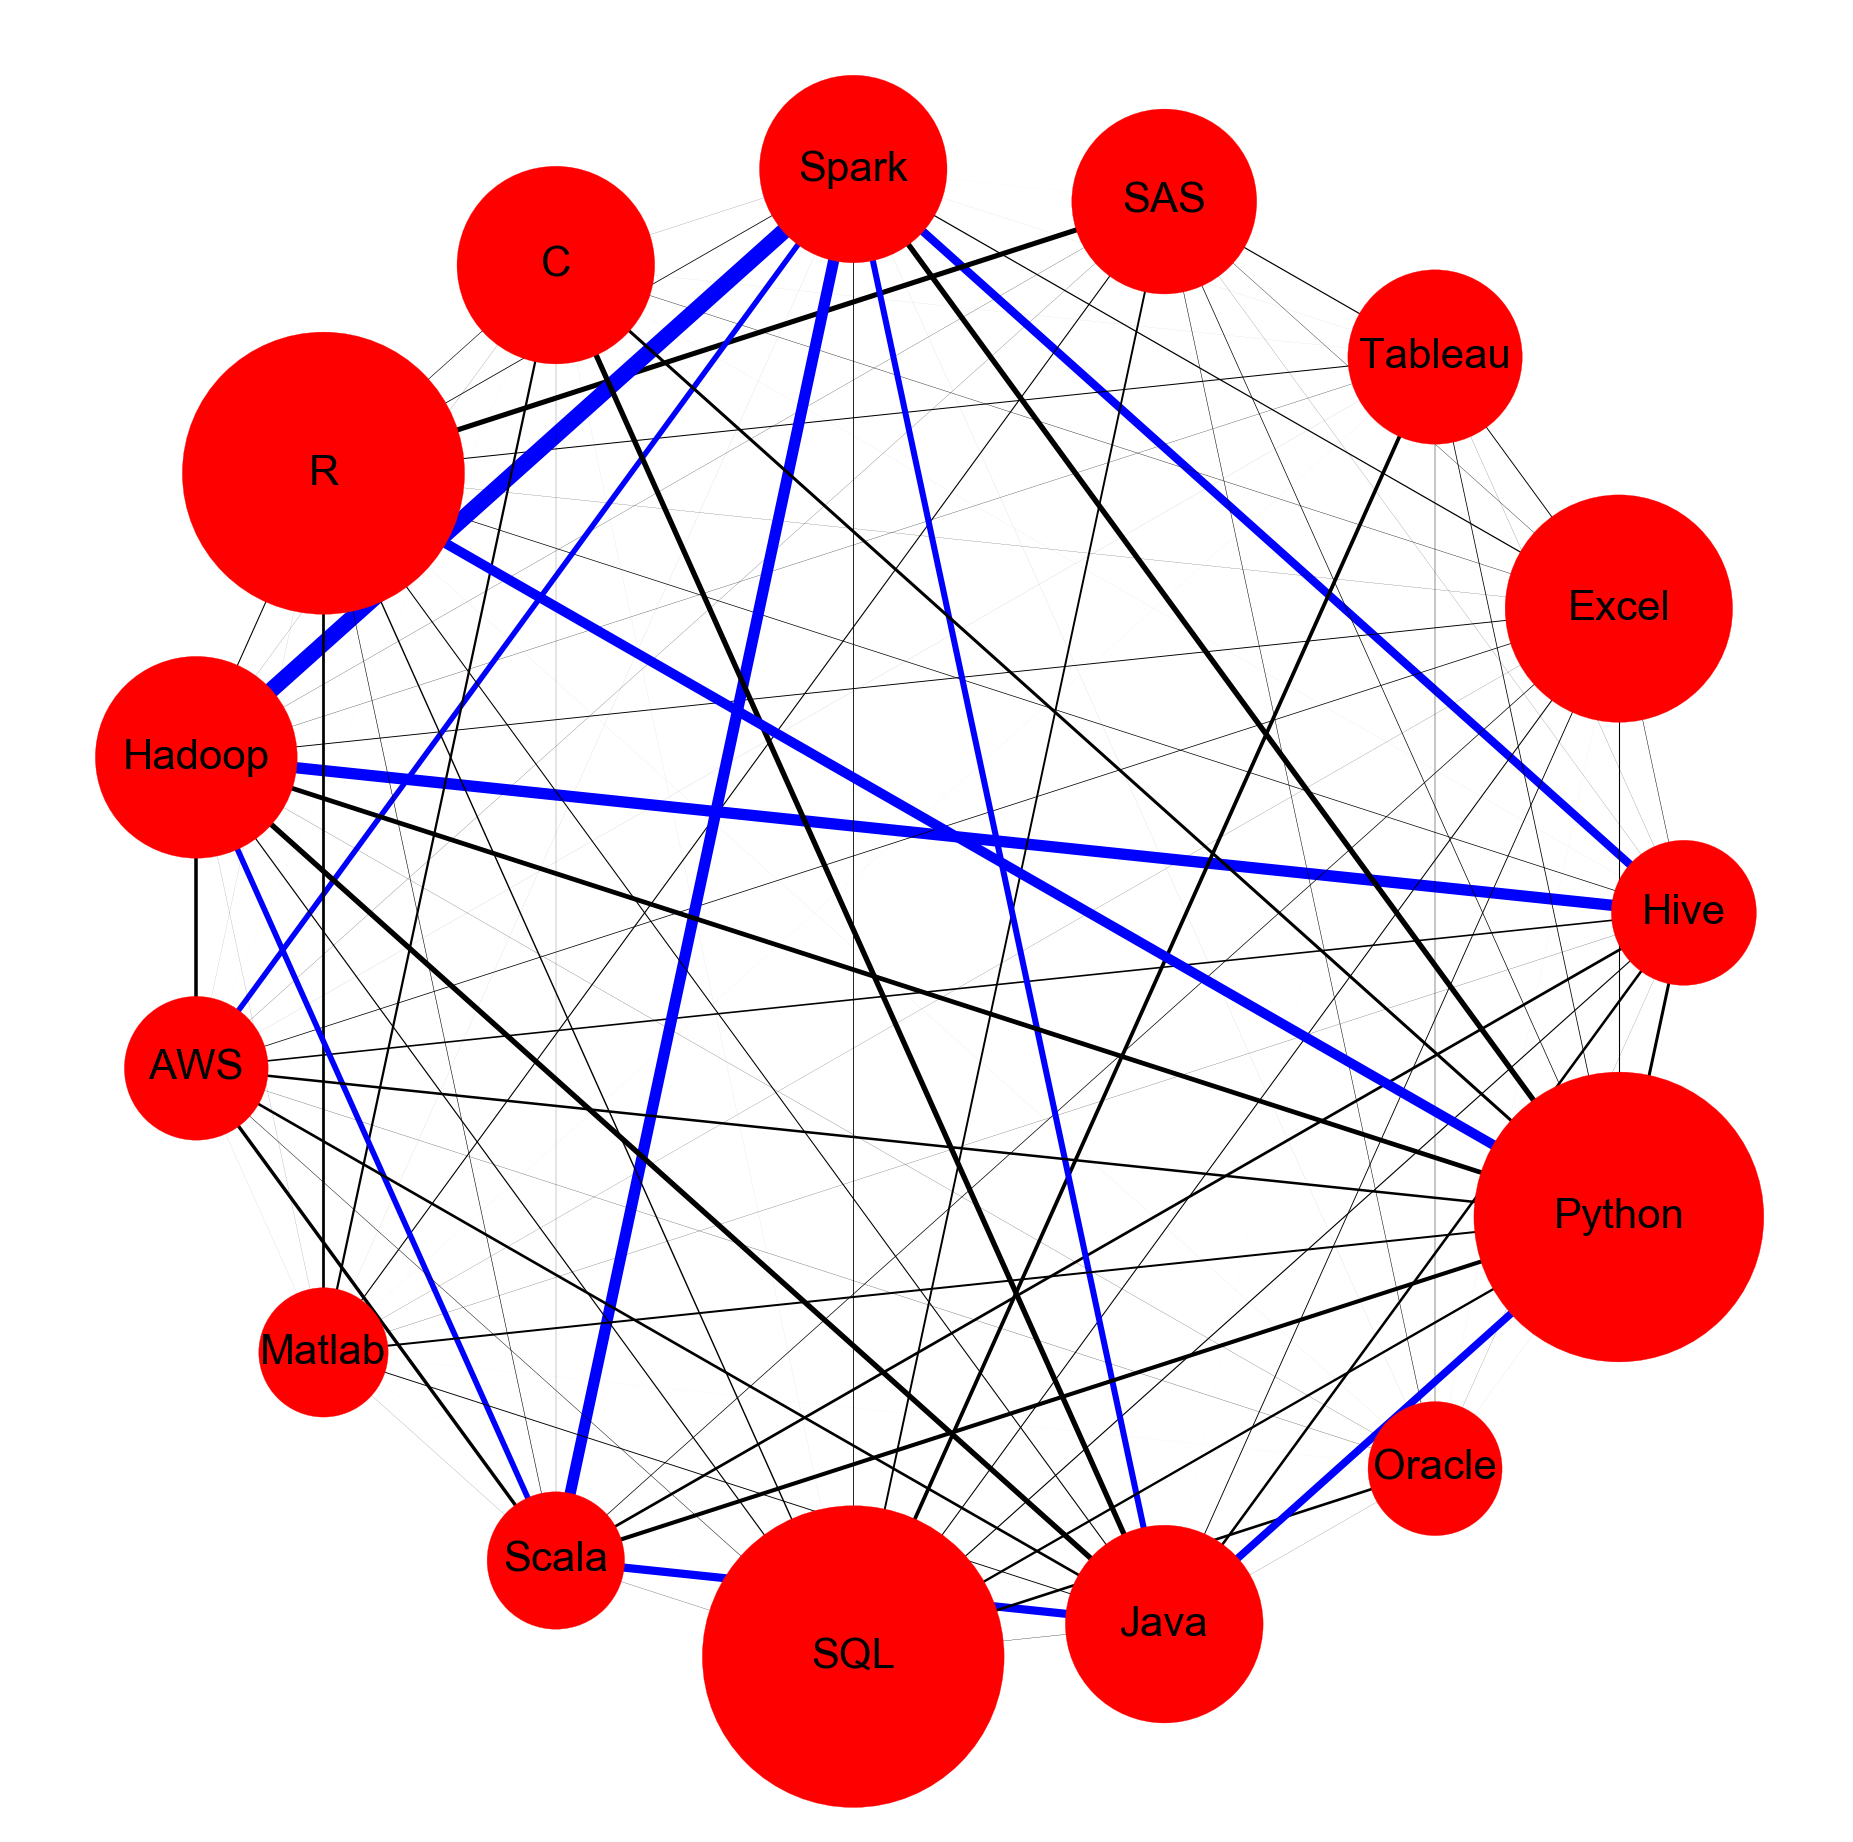

time: 1.59 s


In [304]:
plt.figure(figsize=(25,25))
sizes = [G.node[node]['nodesize']*13 for node in G]
edge_widths = [np.square(G[u][v]['weight'])/5 for u,v in G.edges()]
idxs = np.argsort(edge_widths)
colors = ['b' if idx in idxs[-10:] else 'k' for idx in sorted(idxs)]
nx.draw_shell(G, node_size=sizes, with_labels=True, width=edge_widths, font_size=42, edge_color=colors)
ax = plt.gca()
plt.show()

In [171]:
# Get the average salary for each title (and also a dictionary of the salary and title for every job posting)
def get_salaries_by_title(titles, num_titles=25):
    mean_salary_by_title = {}
    salary_by_title = {}
    counts = pd.Series(titles).value_counts()
    for title in counts.sort_values(ascending=False)[0:num_titles].index:
        salary_by_title[title] = []
        for idx,title_name in enumerate(titles):
            if title == title_name:
                sal = salary[idx]
                if np.isfinite(sal):
                    salary_by_title[title].append(sal)
        mean_salary_by_title[title] = np.mean(salary_by_title[title])
    return sorted(mean_salary_by_title.items(), key=operator.itemgetter(1), reverse=True), salary_by_title

time: 39.8 ms


In [172]:
# Get the average salary for each state (and also a dictionary of the salary and state for every job posting)
def get_salaries_by_state(states, num_states=50):
    mean_salary_by_state = {}
    salary_by_state = {}
    counts = pd.Series(states).value_counts()
    for state in counts.sort_values(ascending=False)[0:num_states].index:
        salary_by_state[state] = []
        for idx,state_name in enumerate(states):
            if state == state_name:
                sal = salary[idx]
                if np.isfinite(sal):
                    salary_by_state[state].append(sal)
        mean_salary_by_state[state] = np.mean(salary_by_state[state])
    return sorted(mean_salary_by_state.items(), key=operator.itemgetter(1), reverse=True), salary_by_state

time: 14.5 ms


In [173]:
# Get the average salary for each skill (and also a dictionary of the salary and skill for every job posting)
def get_salaries_by_skill(skills_counts, num_skills=25):
    mean_salary_by_skill = {}
    salary_by_skill = {}
    for skill in sorted(skills_counts.items(), key=operator.itemgetter(1), reverse=True)[0:num_skills]:
        skill = skill[0]
        salary_by_skill[skill] = []
        for idx,description in enumerate(descriptions):
            if re.search("\\b(" + re.escape(skill) + ")\\b", description, re.IGNORECASE):
                sal = salary[idx]
                if np.isfinite(sal):
                    salary_by_skill[skill].append(sal)
        mean_salary_by_skill[skill] = np.mean(salary_by_skill[skill])
    return sorted(mean_salary_by_skill.items(), key=operator.itemgetter(1), reverse=True), salary_by_skill

time: 558 ms


In [174]:
# Get the average salary for each software (and also a dictionary of the salary and software for every job posting)
def get_salaries_by_software(software_counts, num_software=25):
    mean_salary_by_software = {}
    salary_by_software = {}
    for software in sorted(software_counts.items(), key=operator.itemgetter(1), reverse=True)[0:num_software]:
        software = software[0]
        salary_by_software[software] = []
        for idx,description in enumerate(descriptions):
            if re.search("\\b(" + re.escape(software) + ")\\b", description, re.IGNORECASE):
                sal = salary[idx]
                if np.isfinite(sal):
                    salary_by_software[software].append(sal)
        mean_salary_by_software[software] = np.mean(salary_by_software[software])
    return sorted(mean_salary_by_software.items(), key=operator.itemgetter(1), reverse=True), salary_by_software

time: 13.4 ms


In [175]:
# Get the average salary for each qualification (and also a dictionary of the salary and qualification for every job posting)
def get_salaries_by_qualification(qualifications=["bachelor", "master", "phd"]):
    mean_salary_by_qualification = {}
    salary_by_qualification = {}
    for qualification in qualifications:
        salary_by_qualification[qualification] = []
        for idx,description in enumerate(descriptions):
            if re.search("\\b(" + re.escape(qualification[:-1]) + "\\.*" + re.escape(qualification[-1]) + ")\\b", description, re.IGNORECASE):
                sal = salary[idx]
                if np.isfinite(sal):
                    salary_by_qualification[qualification].append(sal)
        mean_salary_by_qualification[qualification] = np.mean(salary_by_qualification[qualification])
    return sorted(mean_salary_by_qualification.items(), key=operator.itemgetter(1), reverse=True), salary_by_qualification

time: 15.1 ms


In [176]:
# Format salaries for plotting
def format_salaries(mean_salary_by_item, salary_by_item):
    names_counts = []
    for item in mean_salary_by_item:
        item = item[0]
        names_counts.append(item + " : " + str(len(salary_by_item[item])))
    names = []
    for item in mean_salary_by_item:
        names.append(item[0])
    item_names = []
    item_salaries = []
    for item,salaries in salary_by_item.items():
        item_names.extend(np.repeat(item,len(salaries)))
        item_salaries.extend(salaries)
    return names_counts, names, item_names, item_salaries

time: 9.17 ms


In [177]:
# Create a boxplot for salaries by factor
def generate_salary_plot(mean_salary_by_item, salary_by_item, item):
    names_counts, names, item_names, item_salaries = format_salaries(mean_salary_by_item, salary_by_item)
    sns.set(style="ticks")
    f, ax = plt.subplots(figsize=(25, 25))
    plot = sns.boxplot(y=item_names, x=item_salaries, order=names)
    plot.set_xlabel("Salary",fontsize=30)
    plot.set_ylabel(str(item),fontsize=40)
    plot.set_title("{} vs Median Salary".format(item), fontsize=50)
    plot.tick_params(labelsize=25)
    plot.set_yticklabels(names_counts)
    plot.plot([0,0], [-25,55], 'r--', linewidth = 0)
    
    
    medians = [np.percentile(salary_by_item[item[0]],50) for item in mean_salary_by_item]
    perc_30 = [np.percentile(salary_by_item[item[0]],30) for item in mean_salary_by_item]
    median_labels = [str(np.round(s))[:-2] for s in medians]

    pos = range(len(medians))
    for tick,label in zip(pos,plot.get_yticklabels()):
        plot.text(perc_30[tick], pos[tick], median_labels[tick], size=25, color='k', weight='semibold')
        
        
    return plot

time: 25.7 ms


In [180]:
mean_salary_by_title, salary_by_title = get_salaries_by_title(titles)

time: 107 ms


In [181]:
mean_salary_by_state, salary_by_state = get_salaries_by_state(states)

time: 139 ms


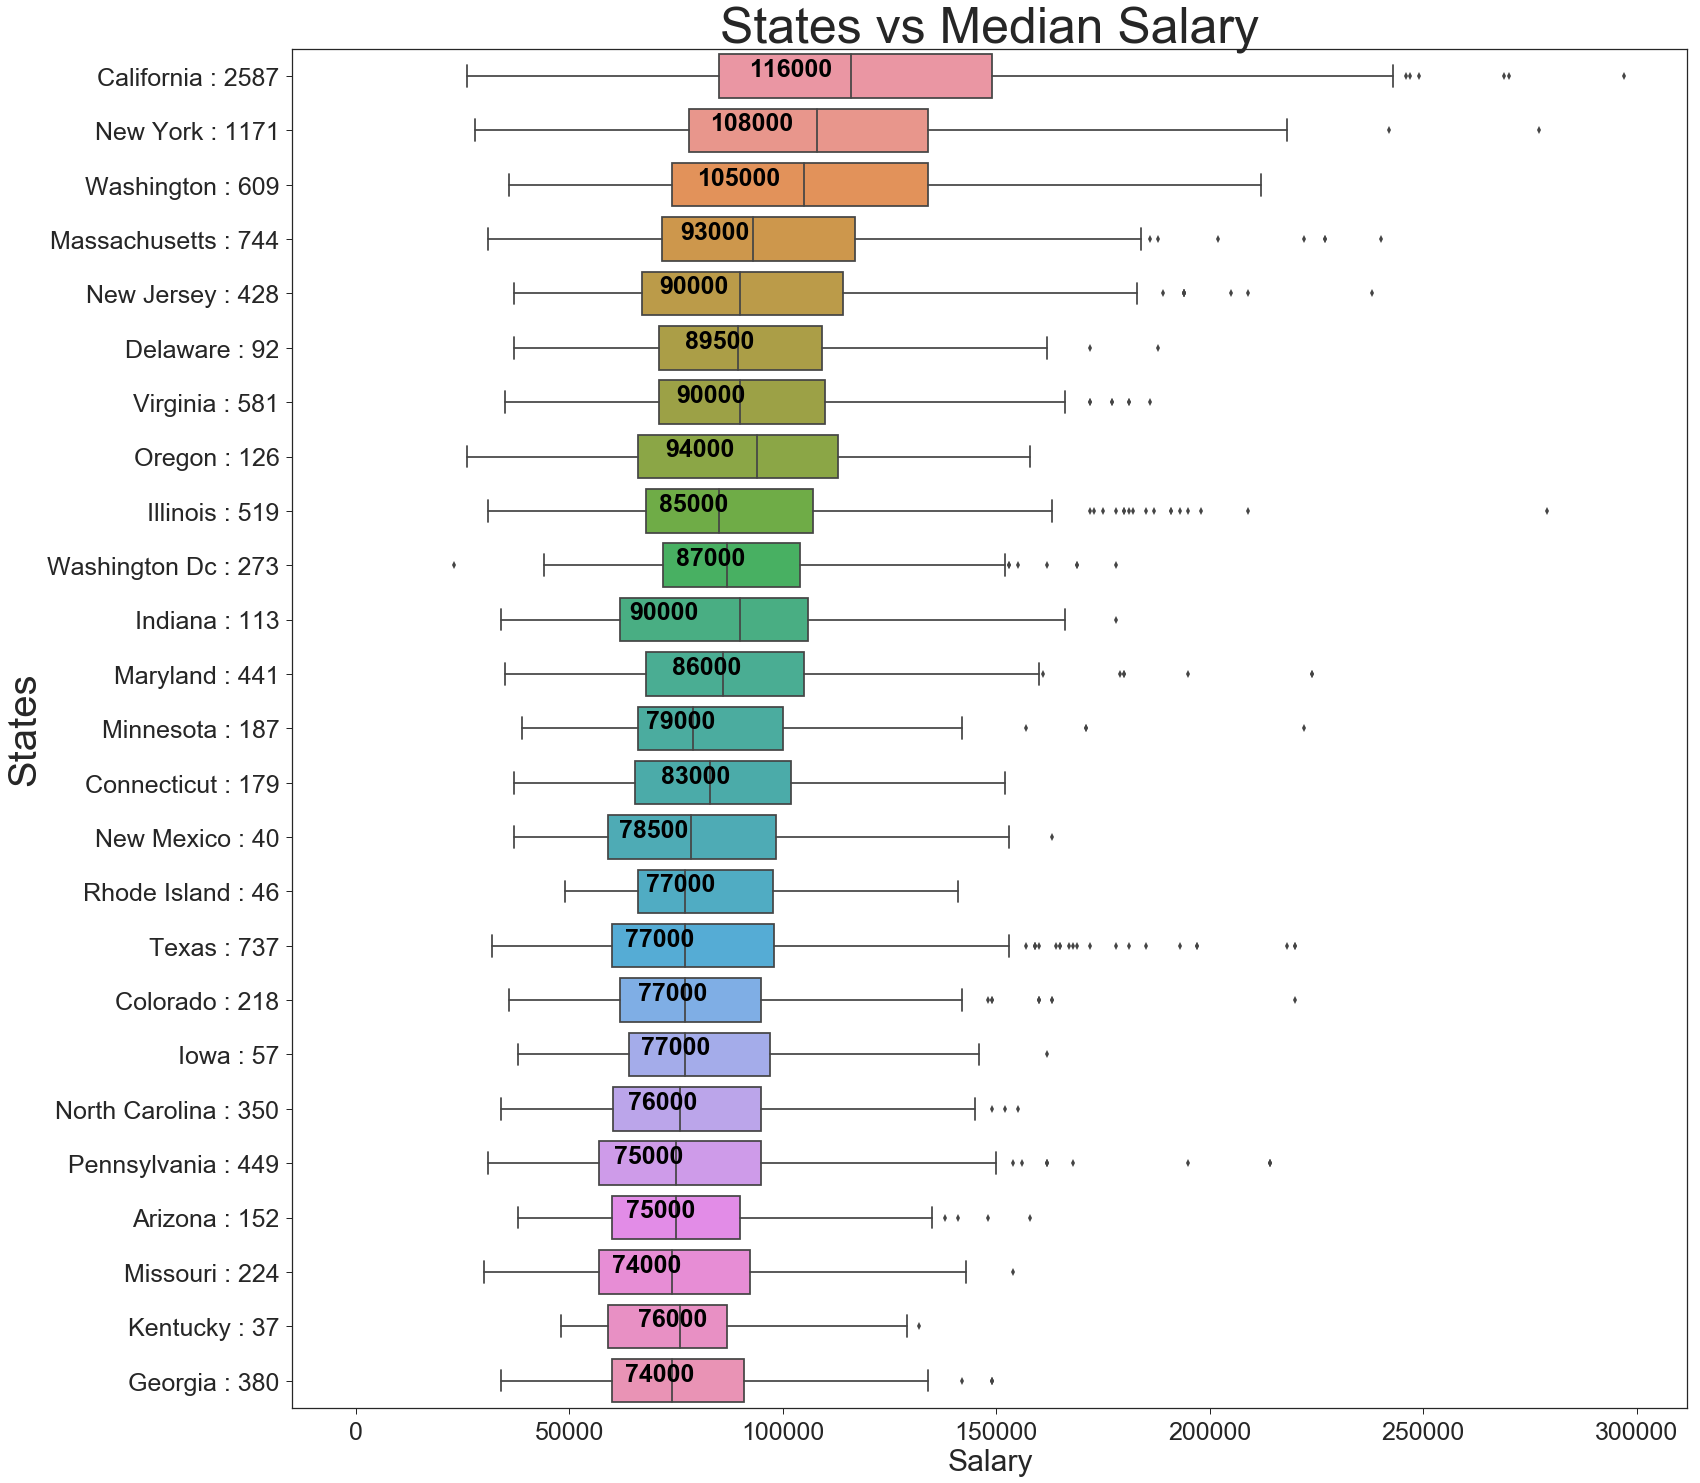

time: 1.98 s


In [182]:
generate_salary_plot(mean_salary_by_state[0:25], salary_by_state, "States")

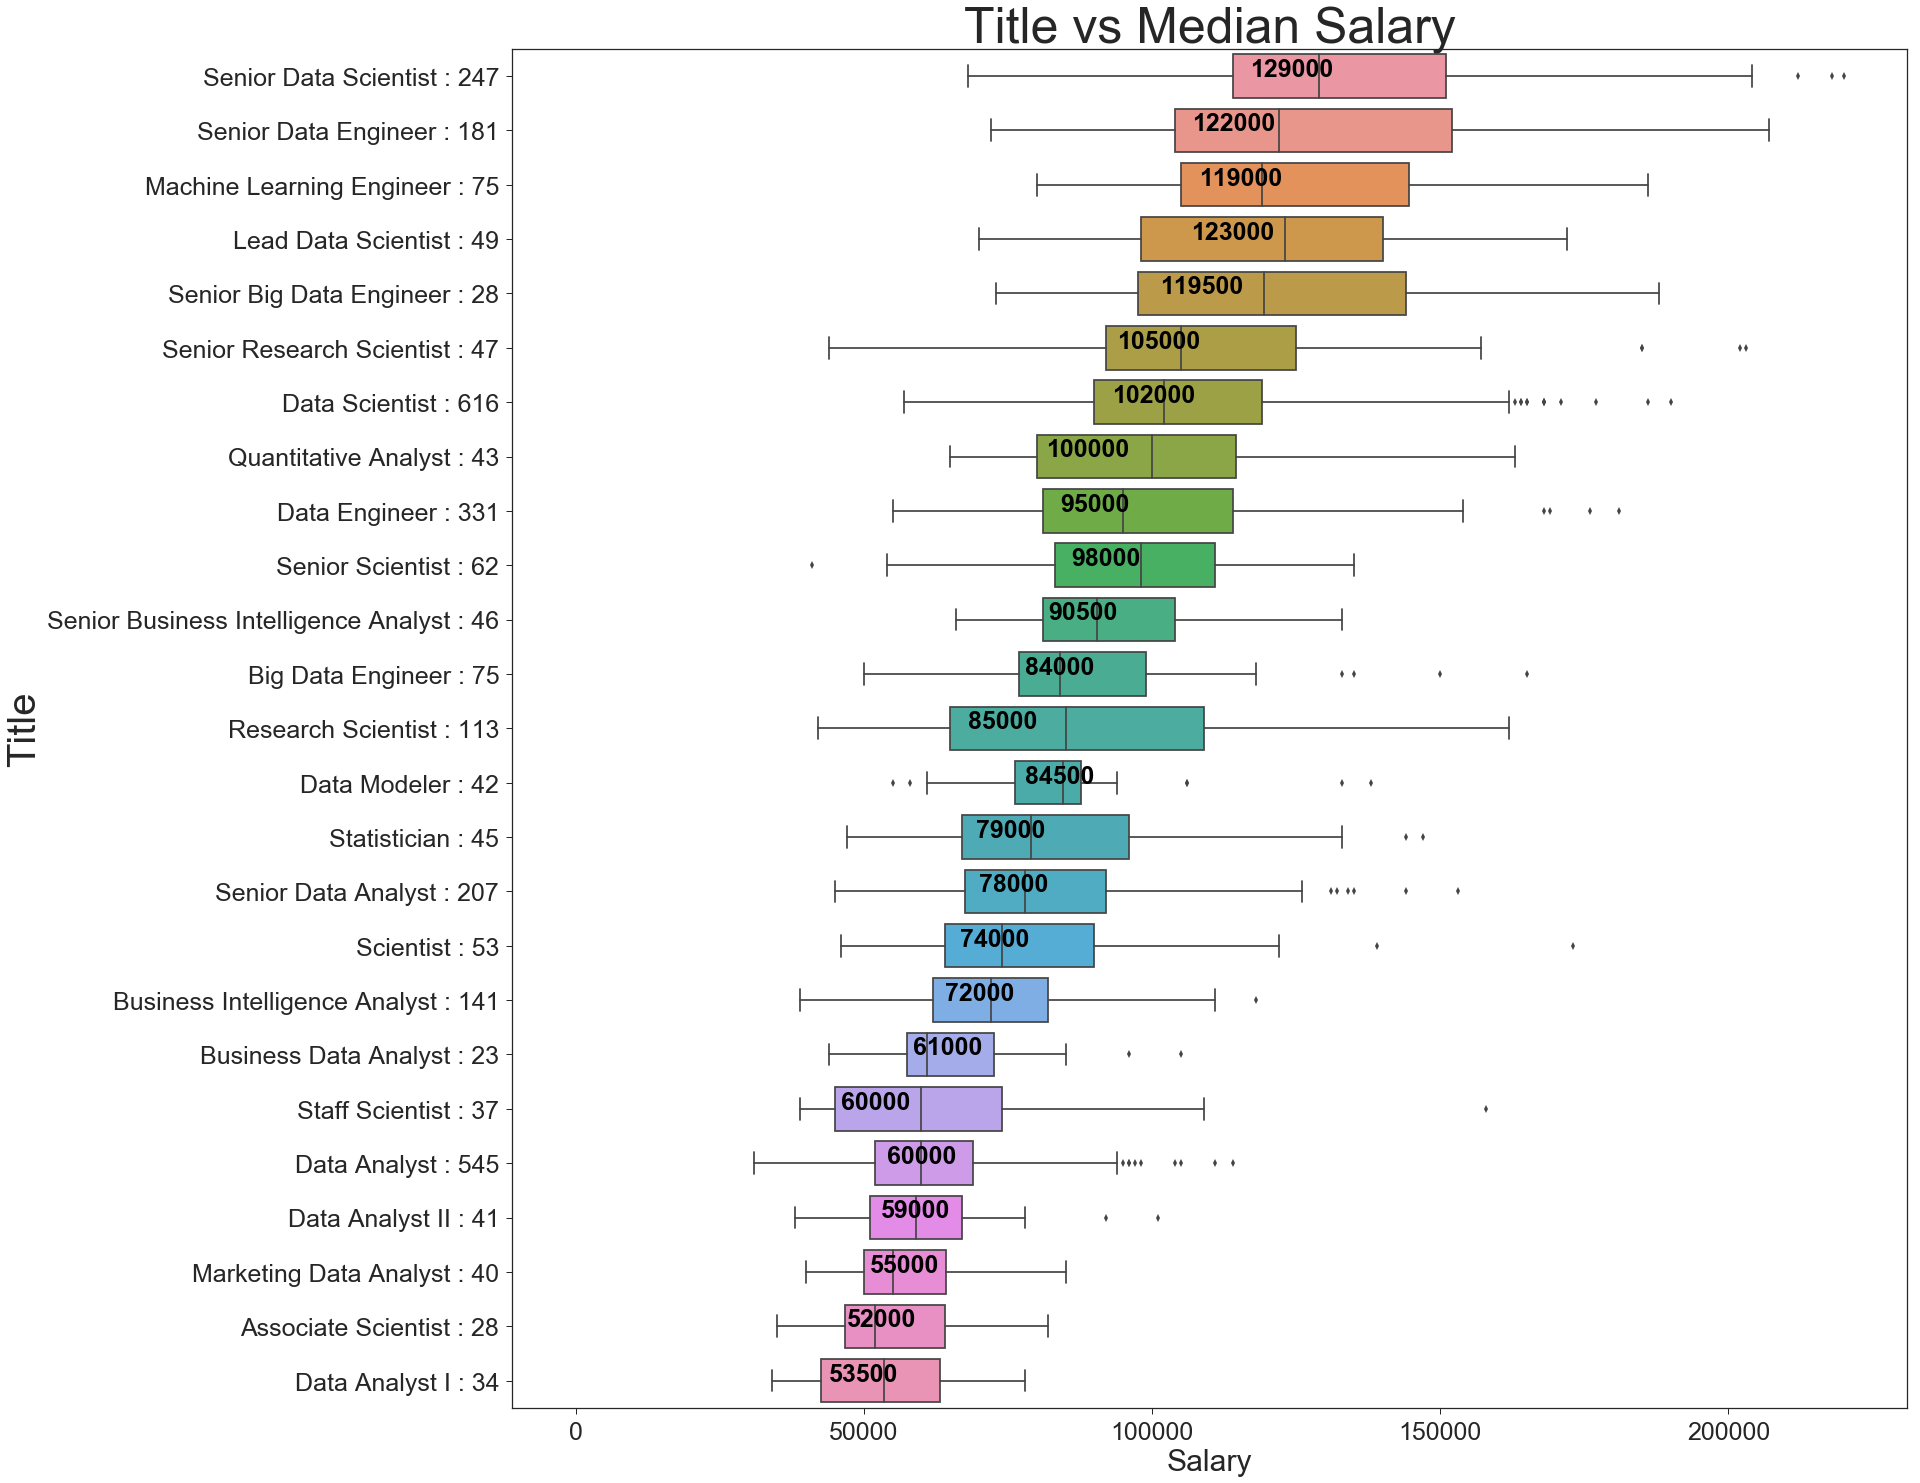

time: 1.72 s


In [183]:
generate_salary_plot(mean_salary_by_title, salary_by_title, "Title")

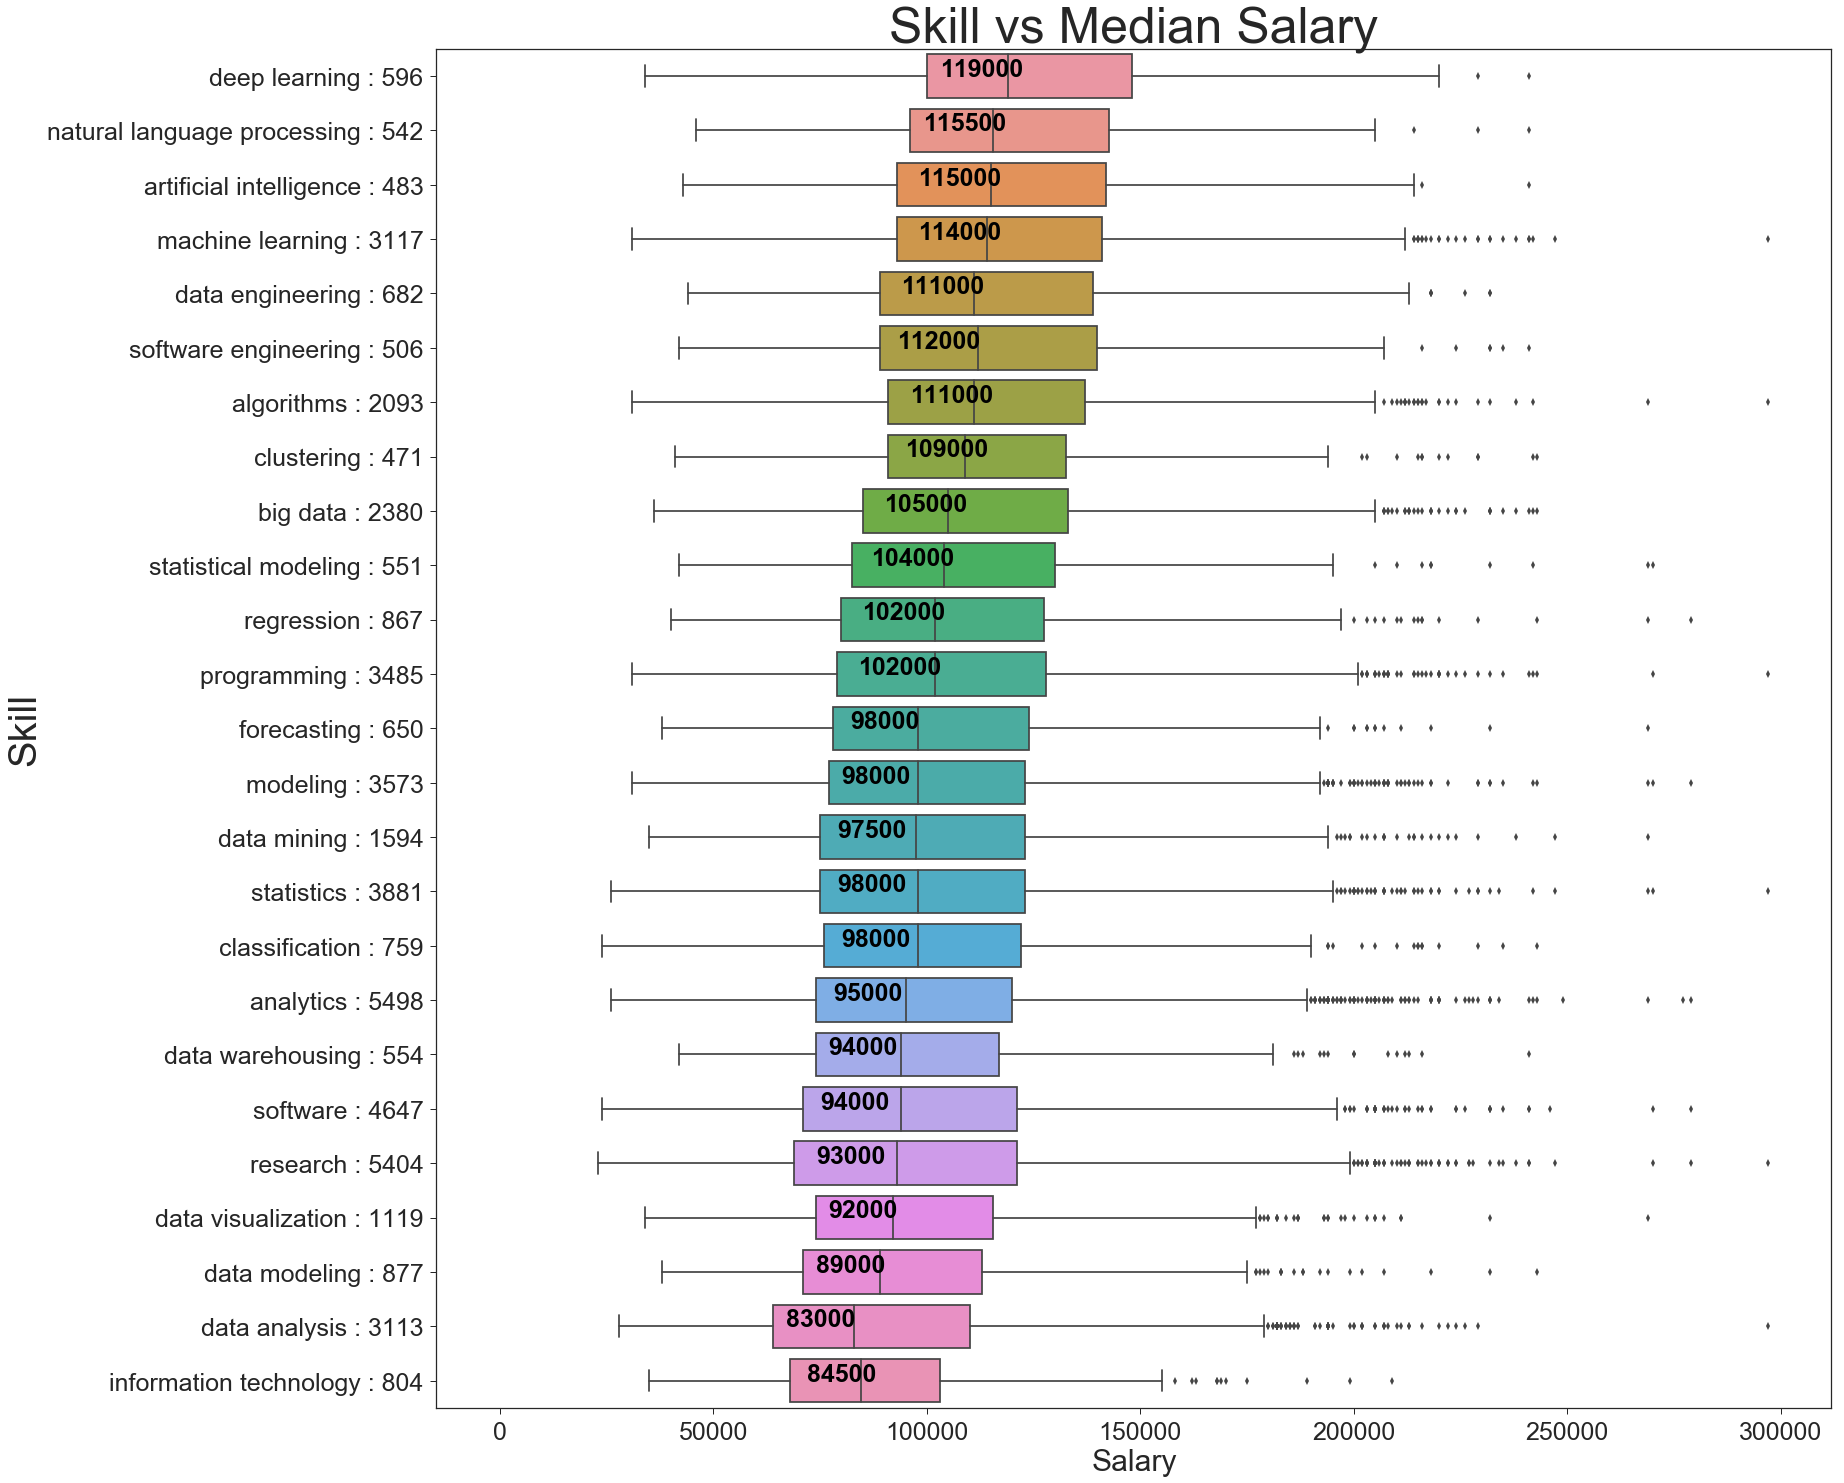

time: 2.01 s


In [184]:
generate_salary_plot(mean_salary_by_skill, salary_by_skill, "Skill")

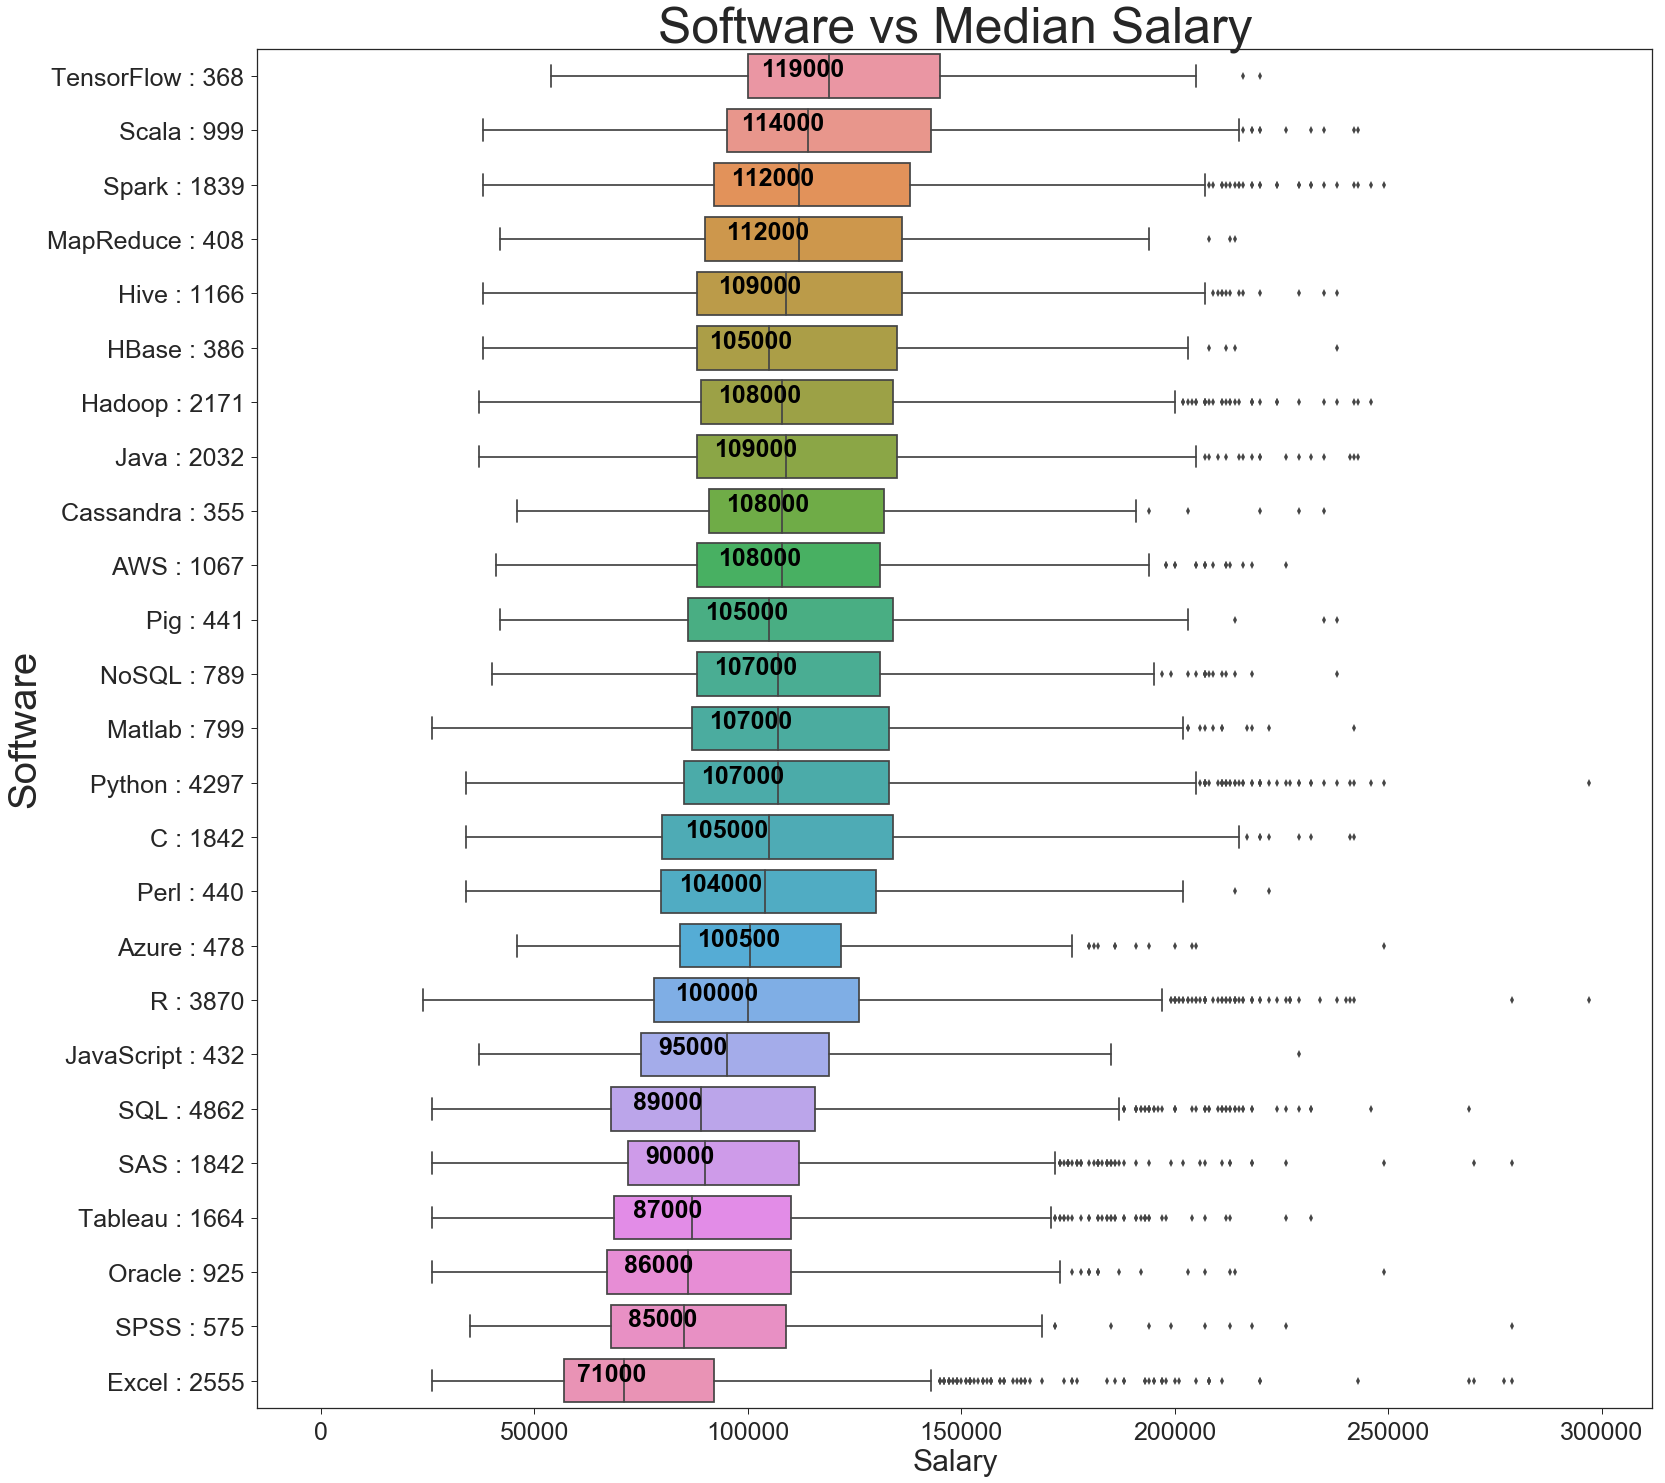

time: 1.86 s


In [185]:
generate_salary_plot(mean_salary_by_software, salary_by_software, "Software")

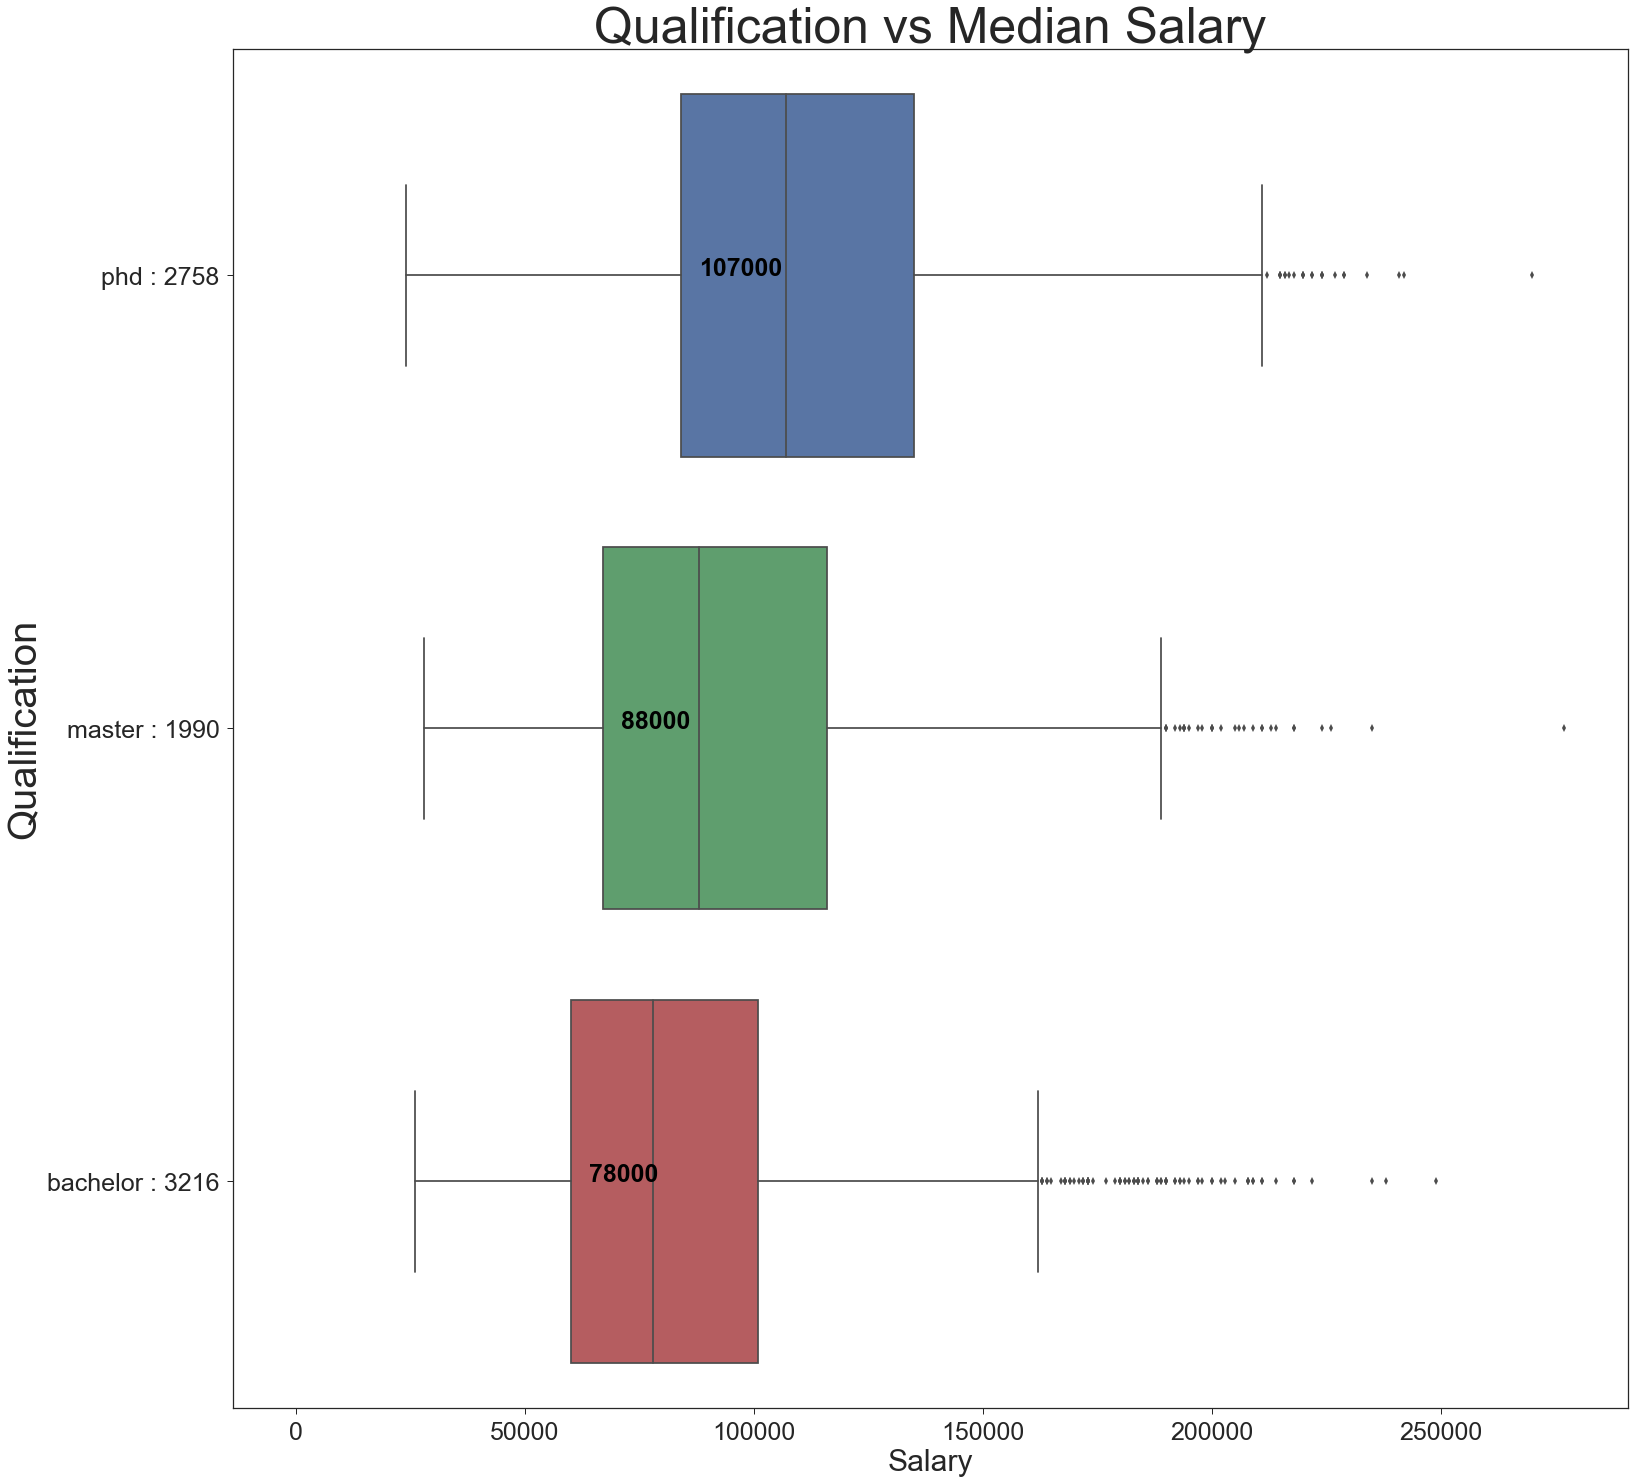

time: 1.2 s


In [667]:
generate_salary_plot(mean_salary_by_qualification, salary_by_qualification, "Qualification")

In [206]:
software_counts = {}
skills_counts = {}
qualification_counts = {}

time: 1.25 ms


In [228]:
for software in ["Python", "R", "SQL", "Hadoop", "Java", "SAS", "Spark", "Hive", "Matlab", "C++", "Tableau", "Scala",
                 "Excel", "Pig", "NoSQL", "MapReduce", "SPSS", "Perl", "Ruby", "HBase", "AWS", "Cassandra", "JavaScript",
                 "D3", "Mahout", "Stata", "MongoDB", "Julia", "Php", "D3.js", "Shark", "Azure", "Octave", "Spotfire", 
                "Flume", "Mathematica", "Oozie", "Zookeeper", "C", "TensorFlow", "ggplot2", "pandas", "scikit-learn", 
                 "PostgreSQL", "SQLite", "MariaDB", "Node.js", "Teradata", "Oracle"]:
    if software not in software_counts:
        software_counts[software] = 0
        for description in descriptions:
            match = re.search("\\b(" + re.escape(software) + ")\\b", description, re.IGNORECASE)
            if match:
                software_counts[software] += 1

time: 1min 58s


In [287]:
list(reversed(sorted(software_counts.items(), key=operator.itemgetter(1))))

[('SQL', 7004),
 ('Python', 6463),
 ('R', 6125),
 ('Excel', 3979),
 ('Hadoop', 3134),
 ('Java', 3008),
 ('C', 3005),
 ('Spark', 2705),
 ('SAS', 2630),
 ('Tableau', 2339),
 ('Hive', 1618),
 ('AWS', 1590),
 ('Scala', 1453),
 ('Oracle', 1382),
 ('Matlab', 1287),
 ('NoSQL', 1168),
 ('SPSS', 822),
 ('Azure', 679),
 ('Perl', 663),
 ('JavaScript', 643),
 ('Pig', 622),
 ('MapReduce', 601),
 ('TensorFlow', 565),
 ('HBase', 560),
 ('Cassandra', 535),
 ('Teradata', 478),
 ('MongoDB', 454),
 ('Ruby', 394),
 ('pandas', 369),
 ('D3', 305),
 ('Stata', 300),
 ('scikit-learn', 293),
 ('PostgreSQL', 277),
 ('Spotfire', 210),
 ('Php', 193),
 ('C++', 155),
 ('D3.js', 131),
 ('Flume', 123),
 ('Oozie', 122),
 ('Mahout', 77),
 ('Node.js', 74),
 ('Julia', 69),
 ('Zookeeper', 66),
 ('Mathematica', 56),
 ('Octave', 42),
 ('ggplot2', 35),
 ('Shark', 11),
 ('SQLite', 8),
 ('MariaDB', 7)]

time: 7.9 ms


In [235]:
for skill in ["data analysis", "data mining", "machine learning", "statistics", "analytics", "statistical modeling", 
              "algorithm design", "big data", "research", "software engineering", 
             "data warehousing", "database design", "data migration", "data modeling", "data visualization", 
             "mathematical modeling", "financial modeling", "forecasting", "predictive analytics", 
              "statistical programming", "statistical computing", "algorithm development", "bayesian statistics", 
             "bayesian methods", "software design", "feature engineering", "data cleaning", "programming", "modeling", 
             "software", "algorithms", "data engineering", "deep learning", "reinforcement learning", "neural networks", 
             "time series analysis", "survival analysis", "computer vision", "natural language processing", 
              "probability theory", "regression", "classification", "clustering", "parallel processing", 
              "distributed computing", "image recognition", "speech recognition", "genetic algorithms", 
              "artificial intelligence", "autonomous vehicle", "web development", "information technology", 
              "system security", "statistical learning", "random forest", "dimension reduction"]:
    if skill not in skills_counts:
        skills_counts[skill] = 0
        for description in descriptions:
            match = re.search("\\b(" + re.escape(skill) + ")\\b", description, re.IGNORECASE)
            if match:
                skills_counts[skill] += 1

time: 2.46 s


In [288]:
list(reversed(sorted(skills_counts.items(), key=operator.itemgetter(1))))

[('research', 8890),
 ('analytics', 7842),
 ('software', 7245),
 ('statistics', 5795),
 ('modeling', 5407),
 ('programming', 5037),
 ('data analysis', 4988),
 ('machine learning', 4789),
 ('big data', 3466),
 ('algorithms', 3247),
 ('data mining', 2315),
 ('data visualization', 1618),
 ('regression', 1305),
 ('data modeling', 1294),
 ('classification', 1286),
 ('information technology', 1272),
 ('deep learning', 973),
 ('data engineering', 944),
 ('forecasting', 914),
 ('natural language processing', 807),
 ('statistical modeling', 806),
 ('data warehousing', 793),
 ('software engineering', 789),
 ('artificial intelligence', 760),
 ('clustering', 718),
 ('predictive analytics', 684),
 ('database design', 481),
 ('neural networks', 474),
 ('distributed computing', 430),
 ('computer vision', 376),
 ('statistical programming', 290),
 ('algorithm development', 246),
 ('feature engineering', 175),
 ('data cleaning', 157),
 ('random forest', 156),
 ('software design', 154),
 ('data migration

time: 28.6 ms


In [277]:
qualification_counts = {}
for qualification in ["bachelor", "master", "phd", "ph.d"]:
    if qualification not in qualification_counts:
        qualification_counts[qualification] = 0
        for description in descriptions:
            match = re.search("\\b(" + re.escape(qualification) + ")\\b", description, re.IGNORECASE)
            if match:
                qualification_counts[qualification] += 1

time: 9.76 s


In [278]:
qualification_counts['phd'] += qualification_counts['ph.d']
qualification_counts.pop('ph.d', None)
qualification_counts

{'bachelor': 4909, 'master': 3202, 'phd': 5038}

time: 9.96 ms


In [ ]:
mean_salary_by_qualification, salary_by_qualification = get_salaries_by_qualification()

In [272]:
mean_salary_by_qualification

[('phd', 110547.39084132055),
 ('master', 93933.668341708544),
 ('bachelor', 83709.888059701494)]

time: 4.37 ms


In [261]:
mean_salary_by_software, salary_by_software = get_salaries_by_software(software_counts)

time: 1.29 ms


In [273]:
mean_salary_by_software

[('TensorFlow', 123035.32608695653),
 ('Scala', 119873.87387387388),
 ('Spark', 117027.18868950517),
 ('MapReduce', 114982.84313725489),
 ('Hive', 113924.52830188679),
 ('HBase', 113515.54404145078),
 ('Hadoop', 113512.20635651774),
 ('Java', 113205.70866141732),
 ('Cassandra', 112529.57746478873),
 ('AWS', 111874.41424554827),
 ('Pig', 111578.23129251701),
 ('NoSQL', 111476.55259822561),
 ('Matlab', 110718.39799749687),
 ('Python', 110572.95787758901),
 ('C', 108904.99457111835),
 ('Perl', 106170.45454545454),
 ('Azure', 105420.50209205021),
 ('R', 104863.82428940569),
 ('JavaScript', 99064.814814814818),
 ('SQL', 95011.106540518304),
 ('SAS', 94973.398479913143),
 ('Tableau', 92444.110576923078),
 ('Oracle', 91804.32432432432),
 ('SPSS', 91003.478260869568),
 ('Excel', 77590.998043052838)]

time: 8.38 ms


In [262]:
mean_salary_by_skill, salary_by_skill = get_salaries_by_skill(skills_counts)

time: 1.35 ms


In [274]:
mean_salary_by_skill

[('deep learning', 123711.40939597315),
 ('natural language processing', 119287.82287822878),
 ('artificial intelligence', 117886.12836438924),
 ('machine learning', 117870.06737247354),
 ('data engineering', 116114.36950146628),
 ('software engineering', 115741.10671936758),
 ('algorithms', 115113.71237458194),
 ('clustering', 114397.02760084925),
 ('big data', 111204.62184873949),
 ('statistical modeling', 109802.1778584392),
 ('regression', 107988.46597462514),
 ('programming', 106001.72166427546),
 ('forecasting', 103936.92307692308),
 ('modeling', 102724.88105233698),
 ('data mining', 102632.37139272271),
 ('statistics', 102359.95877351199),
 ('classification', 102355.73122529645),
 ('analytics', 100082.39359767188),
 ('data warehousing', 98994.584837545131),
 ('software', 98425.650957607053),
 ('research', 97999.814951887485),
 ('data visualization', 97287.75692582663),
 ('data modeling', 94452.679589509688),
 ('data analysis', 90354.641824606486),
 ('information technology', 874

time: 6.64 ms


In [270]:
with open('mean_salary_by_software.json', 'w') as outfile:
    json.dump(mean_salary_by_software, outfile)
with open('salary_by_software.json', 'w') as outfile:
    json.dump(salary_by_software, outfile)
    
with open('mean_salary_by_skill.json', 'w') as outfile:
    json.dump(mean_salary_by_skill, outfile)
with open('salary_by_skill.json', 'w') as outfile:
    json.dump(salary_by_skill, outfile)
    
with open('mean_salary_by_qualification.json', 'w') as outfile:
    json.dump(mean_salary_by_qualification, outfile)
with open('salary_by_qualification.json', 'w') as outfile:
    json.dump(salary_by_qualification, outfile)

time: 143 ms


In [279]:
with open('software_counts.json', 'w') as outfile:
    json.dump(software_counts, outfile)
with open('skills_counts.json', 'w') as outfile:
    json.dump(skills_counts, outfile)
with open('qualification_counts.json', 'w') as outfile:
    json.dump(qualification_counts, outfile)

time: 11.9 ms


In [475]:
columns = ['Title', 'Salary']
for items in [mean_salary_by_software, mean_salary_by_skill, mean_salary_by_qualification]:
    columns.extend([item[0] for item in items])
    
jobs_df = pd.DataFrame(columns=columns)
for idx,description in enumerate(descriptions):
    job_features = [titles[idx],salary[idx]]
    for name in columns[2:]:
        has_features = (None != re.search("\\b(" + re.escape(name[:-1]) + "\\.*" + re.escape(name[-1]) + ")\\b", description, re.IGNORECASE)) * 1
        job_features.append(has_features)
    jobs_df = jobs_df.append(pd.Series(job_features, index=columns), ignore_index=True)
    
jobs_df = pd.concat([jobs_df,pd.get_dummies(states).drop('wyoming', axis=1)],axis=1)
    
jobs_df.to_csv("jobs_df.csv")

time: 6min 32s


In [347]:
jobs_df = pd.read_csv("jobs_df.csv", index_col=0)

time: 825 ms


In [358]:
jobs_df['Grad_Work'] = jobs_df.loc[:,['master', 'phd']].any(axis=1)*1
jobs_df['All_Quals'] = jobs_df.loc[:,['master', 'phd', 'bachelor']].all(axis=1)*1
jobs_df['Bach_Mast'] = jobs_df.loc[:,['master', 'bachelor']].all(axis=1)*1
jobs_df['Bach_Phd'] = jobs_df.loc[:,['phd', 'bachelor']].all(axis=1)*1

time: 152 ms


In [343]:
jobs_df[["Analyst" in tit for tit in titles]].Excel.mean()

0.4145747470962907

time: 64.7 ms


In [346]:
jobs_df[["Analyst" not in tit for tit in titles]].Excel.mean()

0.11619185472728469

time: 25.2 ms


In [350]:
jobs_df.Grad_Work.sum()

7233

time: 45 ms


In [354]:
jobs_df.All_Quals.sum()

316

time: 8.15 ms


In [361]:
jobs_df.bachelor.sum() - jobs_df.Bach_Mast.sum() - jobs_df.Bach_Phd.sum() + jobs_df.All_Quals.sum() 

3270.0

time: 10.7 ms


In [364]:
np.isfinite(jobs_df.Salary).sum()

12468

time: 14 ms


In [372]:
jobs_df[jobs_df.phd == 1].Salary.median()

107000.0

time: 20.3 ms


In [20]:
from scipy.stats import ttest_ind
import statsmodels.stats.api as sms

time: 632 ms


In [14]:
jobs_df = pd.read_csv("jobs_df.csv", index_col=0)

time: 704 ms


In [15]:
ttest_ind(jobs_df.Python, jobs_df.R)

Ttest_indResult(statistic=3.6179679714234907, pvalue=0.0002972811551016179)

time: 12.1 ms


In [16]:
jobs_df = jobs_df[np.isfinite(jobs_df.Salary)]

time: 20.4 ms


In [17]:
ttest_ind(jobs_df[jobs_df.Python==1].Salary, jobs_df[jobs_df.R==1].Salary)

Ttest_indResult(statistic=7.2471578229046072, pvalue=4.6442414202475713e-13)

time: 81.4 ms


In [21]:
cm = sms.CompareMeans(sms.DescrStatsW(jobs_df[jobs_df.Python==1].Salary), sms.DescrStatsW(jobs_df[jobs_df.R==1].Salary))
print(cm.tconfint_diff(usevar='unequal'))

(4164.1385800122735, 7254.1285963543705)
time: 350 ms
